[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/evochora/evochora/blob/main/notebooks/presentation_analysis.ipynb?flush_cache=true)

# Evochora — Simulation Analysis

This notebook examines the evolutionary dynamics produced by Evochora's thermodynamics-driven
artificial life simulator. Each section presents a specific aspect of the simulation data
along with guidance on how to read the charts.

**What you'll see:**
1. Population dynamics and thermodynamic state
2. Generation depth and evolutionary progress
3. Instruction usage and behavioral evolution
4. Genome diversity and selective sweeps
5. Effective mutation rate
6. Multi-dimensional thermodynamic analysis
7. Phylogenetic trees of active lineages
8. A Muller plot showing lineage clade dynamics over time
9. Population census at the final tick
10. Cross-metric analysis with DuckDB

**Requirements:** A running Evochora instance. Point `BASE_URL` below to your instance
or use the public demo.

Configure the Evochora server and simulation run to analyze.

In [1]:
# Point this to your Evochora instance
BASE_URL = "https://evochora.org"  # Public demo
#BASE_URL = "http://localhost:8081"  # Local instance

# Uncomment and set to analyze a specific run (default: longest available)
#RUN_ID = "20260220-22015707-f7b4ede2-5b07-4d19-854b-557b134d879e"

---
Install dependencies and set up API helper.

In [2]:
import subprocess, sys, json, io
from concurrent.futures import ThreadPoolExecutor

# Install dependencies if needed (for Colab)
try:
    import requests, pyarrow.parquet
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                           "requests", "pandas", "numpy", "matplotlib", "networkx", "pyarrow"])
    import requests, pyarrow.parquet

def api_get(url, **kwargs):
    resp = requests.get(url, **kwargs)
    resp.raise_for_status()
    return resp.json()

# Resolve RUN_ID: use configured value or auto-select longest run
try:
    RUN_ID
except NameError:
    RUN_ID = None

if RUN_ID is None:
    runs = api_get(f"{BASE_URL}/analyzer/api/runs")
    def _get_max_tick(r):
        try:
            t = api_get(f"{BASE_URL}/visualizer/api/organisms/ticks",
                        params={"runId": r['runId']})
            return r['runId'], t['maxTick']
        except requests.HTTPError:
            return r['runId'], -1
    with ThreadPoolExecutor(max_workers=len(runs)) as pool:
        results = list(pool.map(_get_max_tick, runs))
    results = [(rid, tick) for rid, tick in results if tick >= 0]
    if not results:
        raise RuntimeError(
            f"None of the {len(runs)} analyzer runs have visualizer data. "
            "Make sure the visualizer has indexed at least one run.")
    RUN_ID = max(results, key=lambda x: x[1])[0]
    print(f"Auto-selected run: {RUN_ID}")
else:
    runs = api_get(f"{BASE_URL}/analyzer/api/runs")
    valid_ids = {r['runId'] for r in runs}
    if RUN_ID not in valid_ids:
        print(f"WARNING: Run '{RUN_ID}' not found. Available runs:")
        for r in runs:
            print(f"  {r['runId']}")
        raise ValueError(f"Run '{RUN_ID}' not found on {BASE_URL}")
    print(f"Using configured run: {RUN_ID}")

Auto-selected run: 20260218-16420964-0d1975f9-0763-4263-b248-26aa0253cc84


---
Fetch all data and set up presentation theme.

In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from collections import Counter
import networkx as nx
from concurrent.futures import ThreadPoolExecutor

# --- Selected run ---
run_params = {"runId": RUN_ID}

ticks_meta = api_get(f"{BASE_URL}/visualizer/api/organisms/ticks", params=run_params)
MAX_TICK = ticks_meta["maxTick"]
sim_metadata = api_get(f"{BASE_URL}/visualizer/api/simulation/metadata", params=run_params)
TICK_INTERVAL = sim_metadata.get("samplingInterval", 1000)

resolved_config = json.loads(sim_metadata.get('resolvedConfigJson', '{}'))
runtime_cfg = resolved_config.get('runtime', {}).get('organism', {})
MAX_ENERGY = runtime_cfg.get('max-energy', 32767)
MAX_ENTROPY = runtime_cfg.get('max-entropy', 8191)

# --- Fetch all analyzer metrics (parallel, Parquet) ---
METRICS = ["population", "vital_stats", "genome_population",
           "generation_depth", "instruction_usage", "genome_diversity"]

def _fetch_parquet(metric):
    resp = requests.get(f"{BASE_URL}/analyzer/api/parquet",
                        params={**run_params, "metric": metric, "lod": "lod0"})
    resp.raise_for_status()
    lod = resp.headers.get('X-LOD-Level', '?')
    df = pd.read_parquet(io.BytesIO(resp.content))
    return metric, df, lod

print("Fetching analyzer metrics...", flush=True)
with ThreadPoolExecutor(max_workers=len(METRICS)) as pool:
    results = list(pool.map(_fetch_parquet, METRICS))

metrics = {}
for metric, df, lod in results:
    metrics[metric] = df
    print(f"  {metric}: {len(df):,} rows (LOD: {lod})")

# --- Fetch lineage tree (1x Visualizer call) ---
print("Fetching lineage tree...", flush=True)
lineage_data = api_get(f"{BASE_URL}/visualizer/api/organisms/{MAX_TICK}", params=run_params)
lineage_organisms = lineage_data['organisms']
lineage_tree_raw = lineage_data['genomeLineageTree']
lineage_alive = [o for o in lineage_organisms if not o['isDead']]

lineage_G = nx.DiGraph()
for genome, parent in lineage_tree_raw.items():
    lineage_G.add_node(genome)
    if parent is not None:
        lineage_G.add_edge(parent, genome)

lineage_roots = [n for n in lineage_G.nodes() if lineage_G.in_degree(n) == 0]

lineage_depths = {}
for root in lineage_roots:
    lineage_depths[root] = 0
    for u, v in nx.bfs_edges(lineage_G, root):
        lineage_depths[v] = lineage_depths[u] + 1

lineage_genome_pop = {}
for o in lineage_alive:
    gh = str(o['genomeHash'])
    lineage_genome_pop[gh] = lineage_genome_pop.get(gh, 0) + 1
lineage_active_genomes = set(lineage_genome_pop.keys())

print(f"  {len(lineage_tree_raw):,} genomes, {len(lineage_alive):,} alive, "
      f"{len(lineage_active_genomes):,} active")

# --- Fetch organism snapshots for Muller plot (~200x Visualizer calls) ---
pop_df = metrics["population"]
start_candidates = pop_df.loc[pop_df['alive_count'] > 10, 'tick']
start_tick = int(start_candidates.iloc[0]) if len(start_candidates) > 0 else 0

raw_ticks = np.linspace(start_tick, MAX_TICK, 200)
snapshot_ticks = sorted(set(int(round(t / TICK_INTERVAL) * TICK_INTERVAL) for t in raw_ticks))

print(f"Fetching {len(snapshot_ticks)} organism snapshots...", flush=True)
snapshots = {}
for i, t in enumerate(snapshot_ticks):
    snapshots[t] = api_get(f"{BASE_URL}/visualizer/api/organisms/{t}", params=run_params)
    if (i + 1) % 50 == 0 or i == len(snapshot_ticks) - 1:
        print(f"  Progress: {i+1}/{len(snapshot_ticks)}")

# --- Presentation theme ---
plt.rcParams.update({
    'figure.facecolor': '#1a1a2e',
    'axes.facecolor': '#16213e',
    'axes.edgecolor': '#444466',
    'axes.labelcolor': '#e0e0e0',
    'text.color': '#e0e0e0',
    'xtick.color': '#aaaacc',
    'ytick.color': '#aaaacc',
    'grid.color': '#333355',
    'grid.alpha': 0.3,
    'legend.facecolor': '#1a1a2e',
    'legend.edgecolor': '#444466',
    'legend.labelcolor': '#e0e0e0',
    'font.size': 13,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
})

GOLD = '#c8af50'
TEAL = '#50a878'
BLUE = '#5b8bd6'
RED = '#d65b5b'
PURPLE = '#9b7bd6'
ORANGE = '#d6925b'
GRAY = '#aaaacc'

def tick_fmt(x, _):
    if x >= 1e6: return f'{x/1e6:.0f}M'
    elif x >= 1e3: return f'{x/1e3:.0f}K'
    return f'{x:.0f}'

def format_genome_hash(h):
    chars = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
    n = int(h)
    if n < 0: n += (1 << 64)
    result = ''
    for _ in range(6):
        result = chars[n % 62] + result
        n //= 62
    return result

def smooth(arr, window):
    if window <= 1: return arr
    window = min(window, len(arr))
    kernel = np.ones(window) / window
    return np.convolve(arr, kernel, mode='same')

print(f"\nRun: {RUN_ID}")
print(f"Simulation: {MAX_TICK:,} ticks ({MAX_TICK/1e6:.1f}M), sampling interval: {TICK_INTERVAL:,}")
print(f"Thermodynamic limits: energy={MAX_ENERGY:,}, entropy={MAX_ENTROPY:,}")

Fetching analyzer metrics...
  population: 132,350 rows (LOD: lod0)
  vital_stats: 132,350 rows (LOD: lod0)
  genome_population: 132,350 rows (LOD: lod0)
  generation_depth: 132,350 rows (LOD: lod0)
  instruction_usage: 132,350 rows (LOD: lod0)
  genome_diversity: 132,350 rows (LOD: lod0)
Fetching lineage tree...
  17,198 genomes, 59 alive, 30 active
Fetching 200 organism snapshots...
  Progress: 50/200
  Progress: 100/200
  Progress: 150/200
  Progress: 200/200

Run: 20260218-16420964-0d1975f9-0763-4263-b248-26aa0253cc84
Simulation: 132,349,000 ticks (132.3M), sampling interval: 1,000
Thermodynamic limits: energy=150,000, entropy=10,000


---
## 1. Population Dynamics

The population metric tracks the number of living organisms and their average thermodynamic
state (energy, entropy) at each sampled tick.

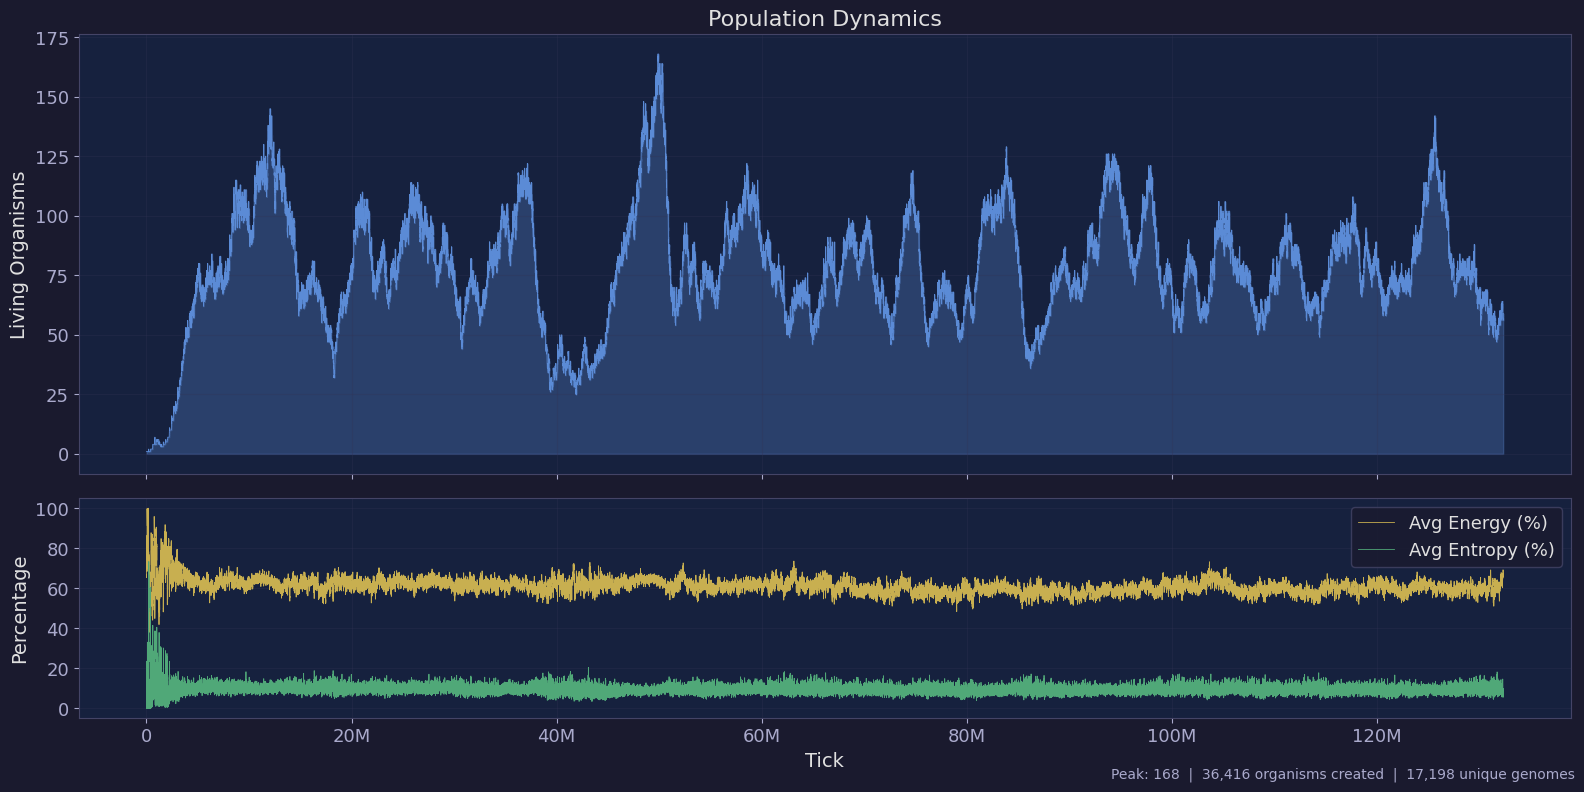

In [4]:
pop = metrics["population"]
vs = metrics["vital_stats"]
gp = metrics["genome_population"]
total_born = int(vs['total_born'].iloc[-1])
total_genomes = int(gp['total_genomes'].iloc[-1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True,
                                gridspec_kw={'height_ratios': [2, 1]})

ax1.fill_between(pop['tick'], pop['alive_count'], alpha=0.3, color=BLUE)
ax1.plot(pop['tick'], pop['alive_count'], color=BLUE, linewidth=0.6)
ax1.set_ylabel('Living Organisms')
ax1.set_title('Population Dynamics')
ax1.grid(True)

ax2.plot(pop['tick'], pop['avg_energy'], color=GOLD, linewidth=0.6, label='Avg Energy (%)')
ax2.plot(pop['tick'], pop['avg_entropy'], color=TEAL, linewidth=0.6, label='Avg Entropy (%)')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Percentage')
ax2.legend(loc='upper right')
ax2.grid(True)
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(tick_fmt))

fig.text(0.99, 0.01,
         f'Peak: {pop["alive_count"].max():,}  |  '
         f'{total_born:,} organisms created  |  '
         f'{total_genomes:,} unique genomes',
         ha='right', va='bottom', fontsize=10, color=GRAY)

plt.tight_layout()
plt.show()

**How to read this chart:**

- **Top panel (population):** The filled area shows the number of living organisms over time.
  A rising curve indicates population growth; a plateau suggests the environment's carrying
  capacity has been reached.
- **Bottom panel (energy/entropy):** The gold line shows the population's average energy
  level as a percentage of maximum. The teal line shows average entropy. Both metrics
  fluctuate more when the population is small (statistical noise from few organisms) and
  stabilize as the population grows.
- **Footer statistics:** Peak population, total organisms ever created, and total unique
  genomes are shown at the bottom right of the chart.

---
## 2. Generation Depth

Generation depth tracks how many reproductive events separate living organisms from the
primordial ancestor. The maximum depth shows the deepest lineage, while the average
reveals the population's typical position in the evolutionary tree.

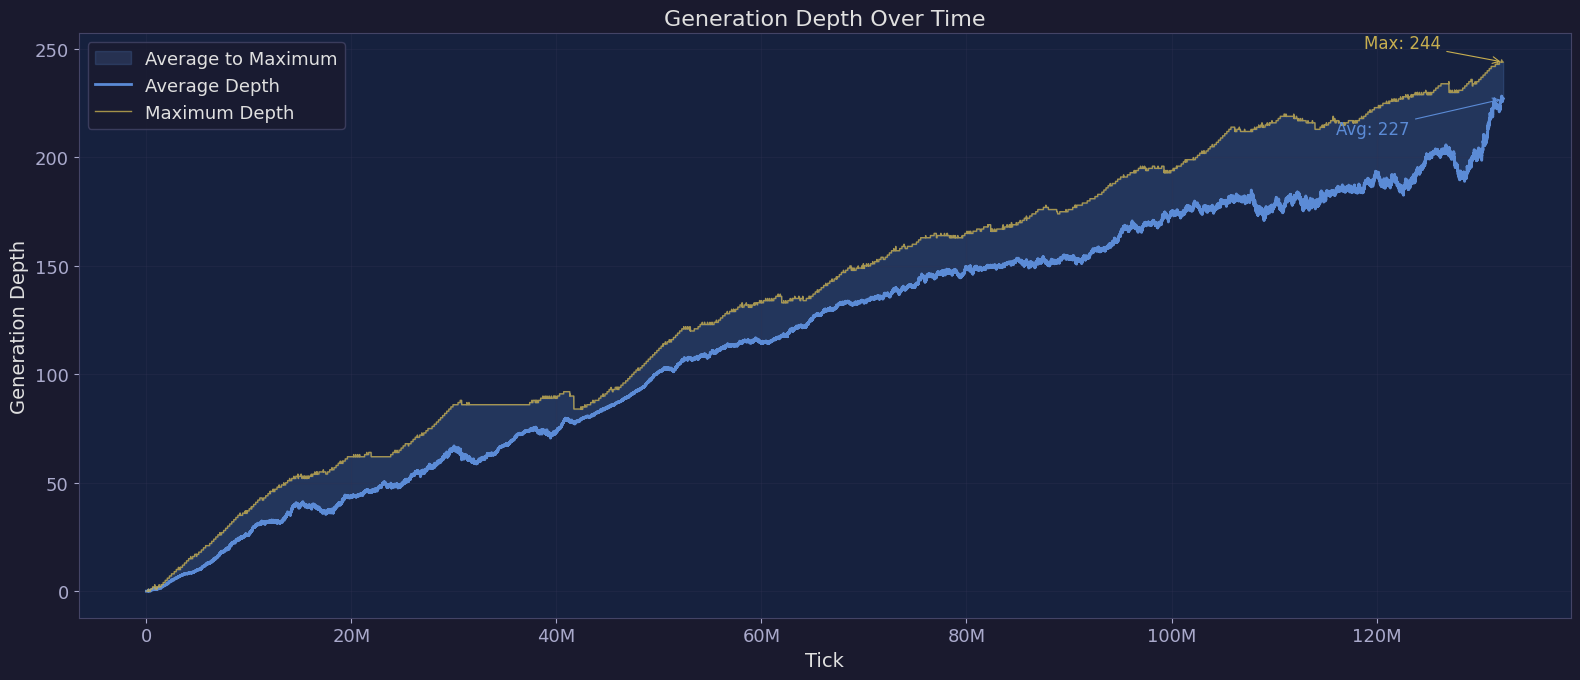

Final average depth: 227
Final maximum depth: 244


In [5]:
gd = metrics["generation_depth"]

fig, ax = plt.subplots(figsize=(16, 7))

ax.fill_between(gd['tick'], gd['avg_depth'], gd['max_depth'], alpha=0.2, color=BLUE,
                label='Average to Maximum')
ax.plot(gd['tick'], gd['avg_depth'], color=BLUE, linewidth=2, label='Average Depth')
ax.plot(gd['tick'], gd['max_depth'], color=GOLD, linewidth=1, alpha=0.8, label='Maximum Depth')

ax.set_xlabel('Tick')
ax.set_ylabel('Generation Depth')
ax.set_title('Generation Depth Over Time')
ax.legend(loc='upper left')
ax.grid(True)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(tick_fmt))

# Annotate final state
final_max = gd['max_depth'].iloc[-1]
final_avg = gd['avg_depth'].iloc[-1]
ax.annotate(f'Max: {final_max:.0f}', xy=(gd['tick'].iloc[-1], final_max),
            xytext=(-100, 10), textcoords='offset points', color=GOLD, fontsize=12,
            arrowprops=dict(arrowstyle='->', color=GOLD, lw=0.8))
ax.annotate(f'Avg: {final_avg:.0f}', xy=(gd['tick'].iloc[-1], final_avg),
            xytext=(-120, -25), textcoords='offset points', color=BLUE, fontsize=12,
            arrowprops=dict(arrowstyle='->', color=BLUE, lw=0.8))

plt.tight_layout()
plt.show()

print(f"Final average depth: {final_avg:.0f}")
print(f"Final maximum depth: {final_max:.0f}")

**How to read this chart:**

- **Blue line (average):** The typical generation depth of a living organism at each point in time.
  A steadily rising average means the population is continuously deepening its lineage.
- **Gold line (maximum):** The deepest lineage in the population.
- **Shaded area:** The gap between average and maximum. A large gap means some lineages are
  much deeper than the typical organism — they have accumulated more reproductive events.
- **Annotations:** The final average and maximum values are annotated on the right side of the chart.

---
## 3. Instruction Usage

Evochora organisms execute a program composed of different instruction categories
(conditional, control flow, data manipulation, environment interaction, etc.).
Tracking the relative usage of each category over time shows how the instruction
mix in the population changes.

We also track the **instruction failure rate**: the fraction of attempted instructions
that fail (e.g., trying to move into occupied space, reproducing without enough energy).

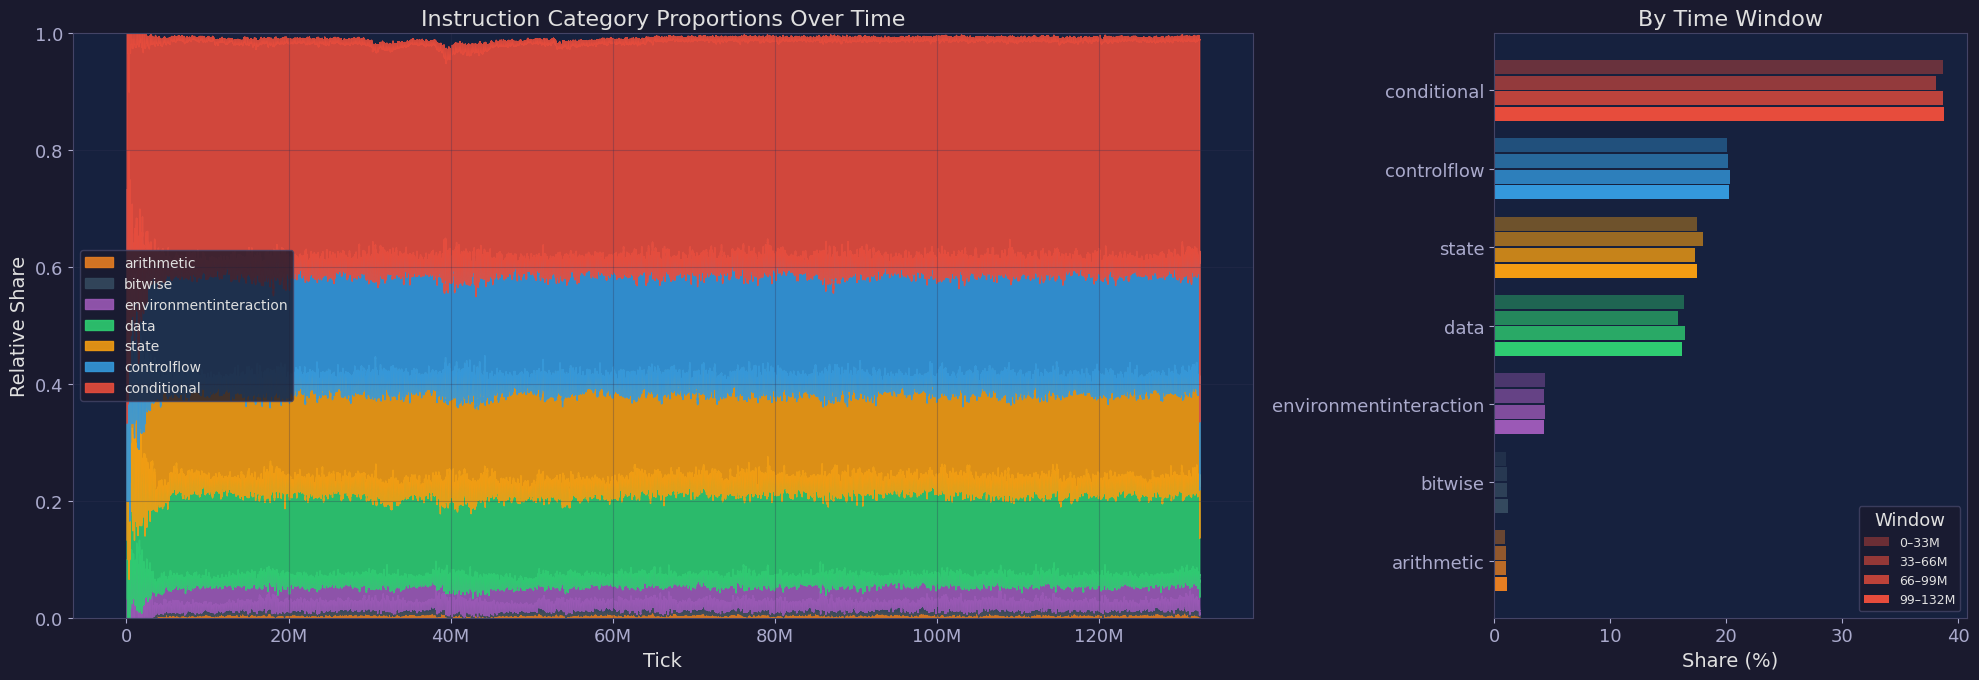

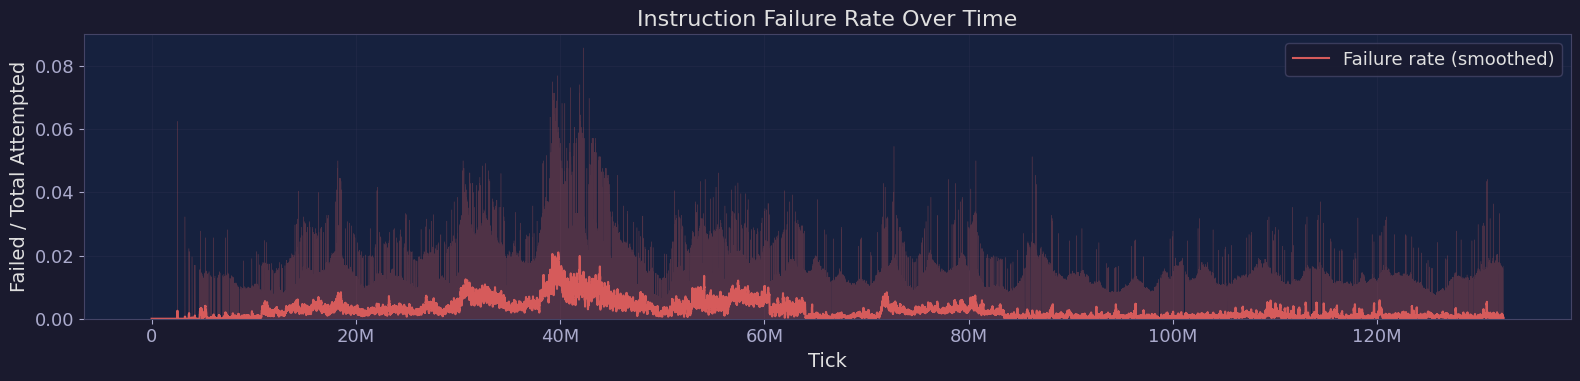

In [6]:
iu = metrics["instruction_usage"]

instr_cols = [c for c in iu.columns if c not in ('tick', 'failure_count')]
totals = iu[instr_cols].sum(axis=1)
iu_rel = iu[instr_cols].div(totals, axis=0).fillna(0)
iu_rel['tick'] = iu['tick']

# Sort by final share, filter to visible categories
final_shares = iu_rel.iloc[-1][instr_cols].sort_values(ascending=False)
top_instr = [c for c in final_shares.index if final_shares[c] > 0.005]

INSTR_COLORS = {
    'conditional': '#e74c3c',
    'controlflow': '#3498db',
    'data': '#2ecc71',
    'state': '#f39c12',
    'environmentinteraction': '#9b59b6',
    'arithmetic': '#e67e22',
    'location': '#1abc9c',
    'bitwise': '#34495e',
    'vector': '#e91e63',
    'nop': '#95a5a6',
    'stack': '#7f8c8d',
}

# Smooth the relative shares to remove visual noise
SM_INSTR = 30
iu_smooth = iu_rel.copy()
for col in top_instr:
    iu_smooth[col] = smooth(iu_rel[col].values, SM_INSTR)

fig, axes = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={'width_ratios': [3, 1.2]})

# Left: stacked area (smoothed)
ax = axes[0]
y_stack = np.zeros(len(iu_smooth))
for col in reversed(top_instr):
    y_new = y_stack + iu_smooth[col].values
    ax.fill_between(iu_smooth['tick'], y_stack, y_new, alpha=0.9,
                    color=INSTR_COLORS.get(col, GRAY), label=col)
    y_stack = y_new
ax.set_xlabel('Tick')
ax.set_ylabel('Relative Share')
ax.set_title('Instruction Category Proportions Over Time')
ax.set_ylim(0, 1)
ax.grid(True)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(tick_fmt))
ax.legend(loc='center left', fontsize=10)

# Right: multi-window comparison (4 equal time windows)
ax = axes[1]
max_tick = iu['tick'].max()
boundaries = np.linspace(0, max_tick, 5)
windows = []
for i in range(4):
    lo, hi = boundaries[i], boundaries[i + 1]
    label = f'{lo/1e6:.0f}–{hi/1e6:.0f}M'
    windows.append((label, iu_rel[(iu_rel.tick >= lo) & (iu_rel.tick < hi)]))
n_win = len(windows)
bar_h = 0.8 / n_win
y_pos = np.arange(len(top_instr))

for wi, (label, window_df) in enumerate(windows):
    means = window_df[top_instr].mean()
    offset = (wi - n_win/2 + 0.5) * bar_h
    alpha = 0.4 + 0.2 * wi  # progressively more opaque
    ax.barh(y_pos + offset, means.values * 100, bar_h * 0.9,
            color=[INSTR_COLORS.get(c, GRAY) for c in top_instr],
            alpha=alpha, label=label)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_instr)
ax.set_xlabel('Share (%)')
ax.set_title('By Time Window')
ax.legend(loc='lower right', fontsize=9, title='Window')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Failure rate chart
total_executions = iu[instr_cols].sum(axis=1)
failure_rate = iu['failure_count'] / (total_executions + iu['failure_count'])
failure_rate_smooth = pd.Series(smooth(failure_rate.values, 50))

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(iu['tick'], failure_rate, color=RED, linewidth=0.3, alpha=0.3)
ax.plot(iu['tick'], failure_rate_smooth, color=RED, linewidth=1.5,
        label='Failure rate (smoothed)')
ax.set_xlabel('Tick')
ax.set_ylabel('Failed / Total Attempted')
ax.set_title('Instruction Failure Rate Over Time')
ax.grid(True)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(tick_fmt))
ax.set_ylim(0, None)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

**How to read these charts:**

- **Stacked area (left):** Each colored band represents one instruction category. The band's
  height shows its relative share of all executed instructions at that point in time.
  A growing band means that category is becoming more prevalent in the population's programs.
  The data is smoothed to show trends rather than per-tick noise.
- **Bar chart (right):** Compares instruction category shares across four equal time windows
  spanning the simulation. Lighter bars = earlier windows, darker bars = later windows.
  Differences between windows reveal how the instruction mix shifts over time.
- **Failure rate (bottom):** The fraction of attempted instructions that fail (e.g., move into
  occupied space, reproduce without enough energy). The faint line is raw data; the solid line
  is a smoothed trend. A declining failure rate suggests the population is adapting to avoid
  wasteful actions.

---
## 4. Genome Diversity

Population genetics predicts that larger populations should sustain more genetic
diversity. We test this relationship and examine whether any single genome achieves
lasting dominance (a "selective sweep").

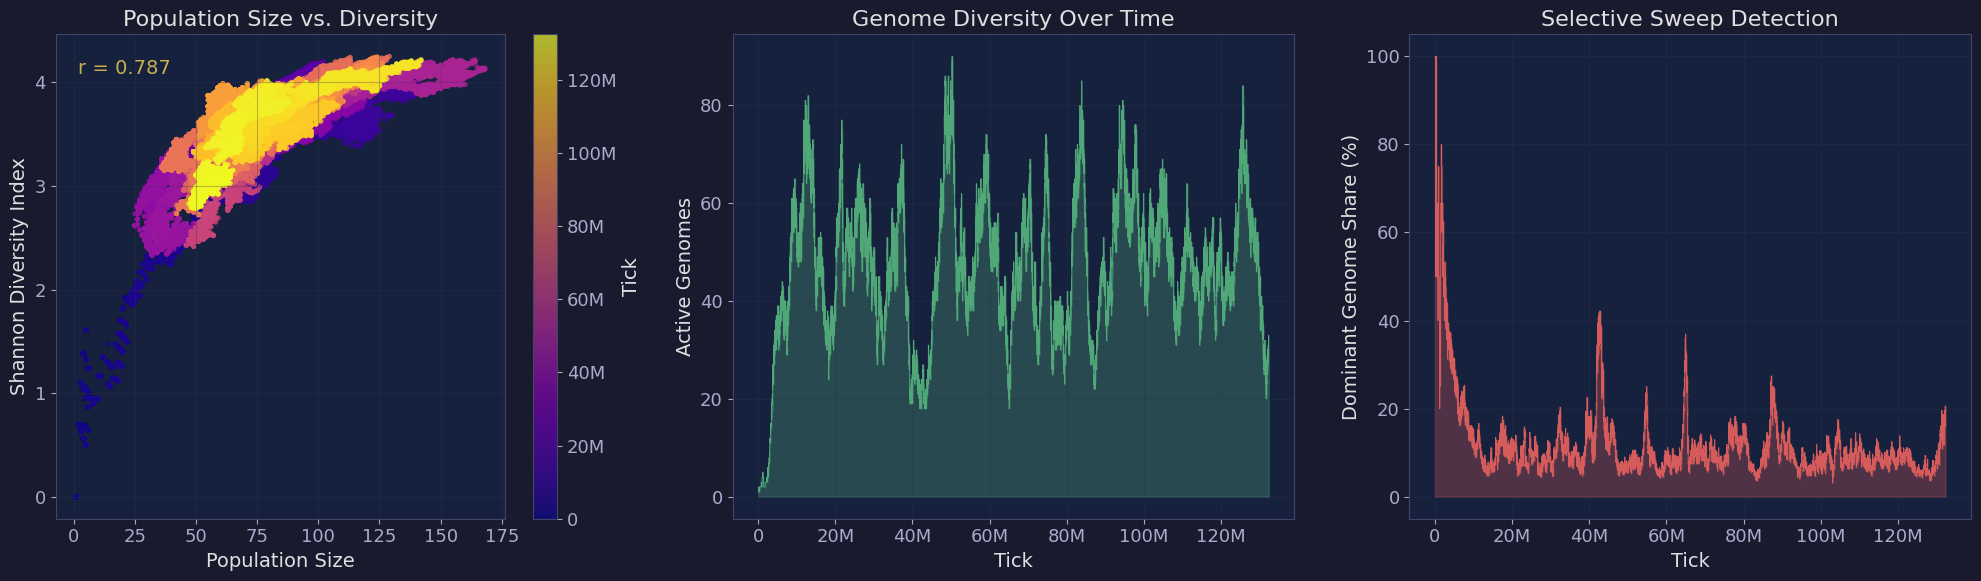

Pearson correlation (population vs. diversity): 0.787
Dominant share range: 3.2% – 100.0%
Final active genomes: 30


In [7]:
pop = metrics["population"]
div = metrics["genome_diversity"]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Left: population vs diversity scatter
sc = axes[0].scatter(pop['alive_count'], div['shannon_index'],
                     c=pop['tick'], cmap='plasma', s=8, alpha=0.7)
plt.colorbar(sc, ax=axes[0], label='Tick', format=mticker.FuncFormatter(tick_fmt))
axes[0].set_xlabel('Population Size')
axes[0].set_ylabel('Shannon Diversity Index')
axes[0].set_title('Population Size vs. Diversity')
axes[0].grid(True)
corr = pop['alive_count'].corr(div['shannon_index'])
axes[0].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[0].transAxes,
             fontsize=14, va='top', color=GOLD)

# Middle: active genomes over time
axes[1].fill_between(div['tick'], div['active_genomes'], alpha=0.3, color=TEAL)
axes[1].plot(div['tick'], div['active_genomes'], color=TEAL, linewidth=0.6)
axes[1].set_xlabel('Tick')
axes[1].set_ylabel('Active Genomes')
axes[1].set_title('Genome Diversity Over Time')
axes[1].grid(True)
axes[1].xaxis.set_major_formatter(mticker.FuncFormatter(tick_fmt))

# Right: dominant share
axes[2].fill_between(div['tick'], div['dominant_share'] * 100, alpha=0.3, color=RED)
axes[2].plot(div['tick'], div['dominant_share'] * 100, color=RED, linewidth=0.6)
axes[2].set_xlabel('Tick')
axes[2].set_ylabel('Dominant Genome Share (%)')
axes[2].set_title('Selective Sweep Detection')
axes[2].grid(True)
axes[2].xaxis.set_major_formatter(mticker.FuncFormatter(tick_fmt))

plt.tight_layout()
plt.show()

print(f"Pearson correlation (population vs. diversity): {corr:.3f}")
print(f"Dominant share range: {div['dominant_share'].min()*100:.1f}% – {div['dominant_share'].max()*100:.1f}%")
print(f"Final active genomes: {div['active_genomes'].iloc[-1]}")

**How to read these charts:**

- **Left (scatter):** Each dot is one sampled tick, with color encoding time progression
  (purple = early, yellow = late). The Pearson correlation coefficient *r* is shown in the
  top-left corner. A positive *r* means larger populations sustain more diversity — consistent
  with population genetics theory.
- **Middle (active genomes):** The number of distinct genomes with at least one living
  organism over time. Rising = new genomes appearing faster than old ones go extinct.
- **Right (dominant share):** The population share held by the single most common genome.
  Starts at 100% when only the primordial ancestor exists. A sustained spike indicates a
  **selective sweep** (one genome outcompeting all others). Low values indicate a diverse,
  multi-lineage population.

---
## 5. Effective Mutation Rate

The effective mutation rate measures how many births produce a new genome. This
determines the balance between exploration and exploitation in evolution.

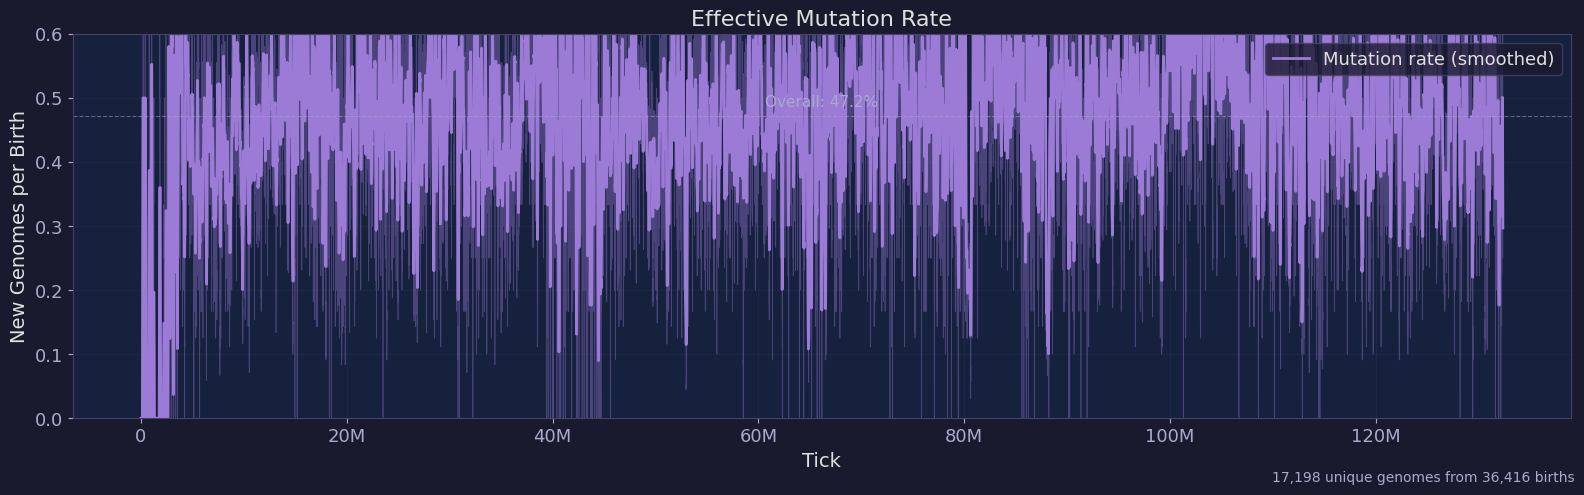

In [8]:
gp = metrics["genome_population"]
vs = metrics["vital_stats"]

# Compute cumulative mutation rate over time
new_genomes = gp['total_genomes'].diff().fillna(0)
new_births = vs['total_born'].diff().fillna(0)

# Rolling mutation rate
window = 50
mut_rate = (new_genomes.rolling(window).sum() / new_births.rolling(window).sum()).fillna(0)

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(gp['tick'], mut_rate, color=PURPLE, linewidth=0.5, alpha=0.4)
mut_smooth = pd.Series(smooth(mut_rate.values, 100), index=mut_rate.index)
ax.plot(gp['tick'], mut_smooth, color=PURPLE, linewidth=2, label='Mutation rate (smoothed)')

ax.set_xlabel('Tick')
ax.set_ylabel('New Genomes per Birth')
ax.set_title('Effective Mutation Rate')
ax.grid(True)
ax.set_ylim(0, 0.6)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(tick_fmt))
ax.legend(loc='upper right')

# Annotate overall rate
total_genomes = gp['total_genomes'].iloc[-1]
total_births = vs['total_born'].iloc[-1]
overall_rate = total_genomes / total_births
ax.axhline(overall_rate, color=GRAY, linestyle='--', linewidth=0.8, alpha=0.5)
ax.text(gp['tick'].iloc[-1] * 0.5, overall_rate + 0.015,
        f'Overall: {overall_rate:.1%}', color=GRAY, fontsize=11, ha='center')

fig.text(0.99, 0.01,
         f'{total_genomes:,.0f} unique genomes from {total_births:,.0f} births',
         ha='right', va='bottom', fontsize=10, color=GRAY)

plt.tight_layout()
plt.show()

**How to read this chart:**

- **Purple line:** The rolling effective mutation rate — the fraction of births that produce
  a genome not seen before. The faint line is raw data; the solid line is smoothed.
- **Dashed horizontal line:** The overall average mutation rate across the entire run.
- **Interpretation:** A rate of 0.2 means 20% of births create a new genome (the other 80%
  produce a genome already observed in the simulation). Higher rates mean more exploration;
  lower rates mean the population is mostly replicating existing genomes.
- The footer shows total unique genomes and total births.

---
## 6. Thermodynamic State — Energy and Entropy

In Evochora, energy and entropy are thermodynamic variables that jointly
determine organism viability. Showing them together with population size and reproductive
rate reveals how the thermodynamic environment and population dynamics interact.

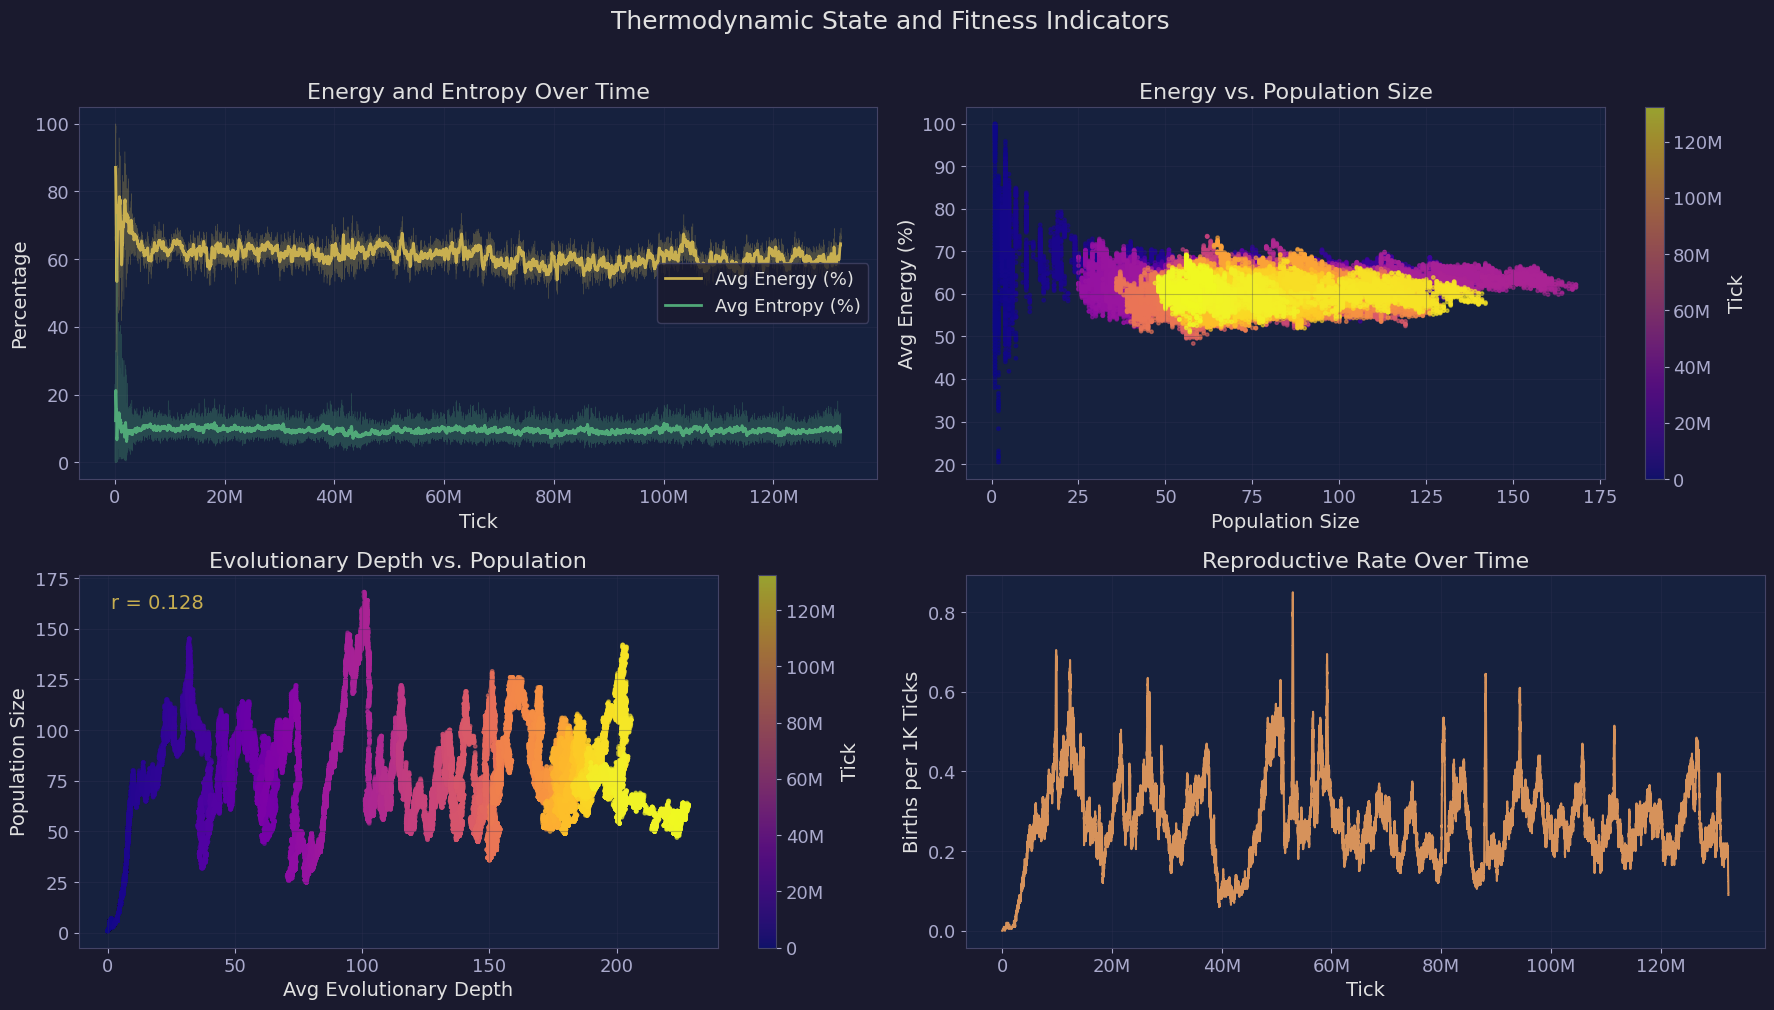

In [9]:
pop = metrics["population"]
gd = metrics["generation_depth"]
vs = metrics["vital_stats"]

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

SM = 200  # smoothing window

# Top-left: Energy + Entropy together
ax = axes[0, 0]
energy_smooth = pop['avg_energy'].rolling(SM, center=True).mean()
entropy_smooth = pop['avg_entropy'].rolling(SM, center=True).mean()

ax.plot(pop['tick'], pop['avg_energy'], color=GOLD, linewidth=0.3, alpha=0.3)
ax.plot(pop['tick'], energy_smooth, color=GOLD, linewidth=2, label='Avg Energy (%)')
ax.plot(pop['tick'], pop['avg_entropy'], color=TEAL, linewidth=0.3, alpha=0.3)
ax.plot(pop['tick'], entropy_smooth, color=TEAL, linewidth=2, label='Avg Entropy (%)')
ax.set_xlabel('Tick')
ax.set_ylabel('Percentage')
ax.set_title('Energy and Entropy Over Time')
ax.legend(loc='right')
ax.grid(True)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(tick_fmt))

# Top-right: Energy vs Population (resource competition)
ax = axes[0, 1]
sc = ax.scatter(pop['alive_count'], pop['avg_energy'],
                c=pop['tick'], cmap='plasma', s=6, alpha=0.6)
plt.colorbar(sc, ax=ax, label='Tick', format=mticker.FuncFormatter(tick_fmt))
ax.set_xlabel('Population Size')
ax.set_ylabel('Avg Energy (%)')
ax.set_title('Energy vs. Population Size')
ax.grid(True)

# Bottom-left: Depth vs Population
ax = axes[1, 0]
merged = pd.merge(gd, pop[['tick', 'alive_count']], on='tick', how='inner')
sc = ax.scatter(merged['avg_depth'], merged['alive_count'],
                c=merged['tick'], cmap='plasma', s=6, alpha=0.6)
plt.colorbar(sc, ax=ax, label='Tick', format=mticker.FuncFormatter(tick_fmt))
ax.set_xlabel('Avg Evolutionary Depth')
ax.set_ylabel('Population Size')
ax.set_title('Evolutionary Depth vs. Population')
ax.grid(True)
corr_dp = merged['avg_depth'].corr(merged['alive_count'])
ax.text(0.05, 0.95, f'r = {corr_dp:.3f}', transform=ax.transAxes,
        fontsize=14, va='top', color=GOLD)

# Bottom-right: Reproductive rate over time
ax = axes[1, 1]
birth_rate = vs['total_born'].diff() / vs['tick'].diff()
birth_smooth = pd.Series(smooth(birth_rate.fillna(0).values, SM))
ax.plot(vs['tick'], birth_smooth * 1000, color=ORANGE, linewidth=1.5)
ax.set_xlabel('Tick')
ax.set_ylabel('Births per 1K Ticks')
ax.set_title('Reproductive Rate Over Time')
ax.grid(True)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(tick_fmt))

plt.suptitle('Thermodynamic State and Fitness Indicators', fontsize=18, y=1.01)
plt.tight_layout()
plt.show()

**How to read these charts:**

- **Energy and entropy** (top-left): Gold = average energy, teal = average entropy. Faint lines
  are raw data, solid lines are smoothed. Both values fluctuate more when the population is small.
- **Energy vs. population** (top-right): Each dot is one tick. Color encodes time (purple = early,
  yellow = late). A negative slope means larger populations have lower per-organism energy —
  a sign of resource competition.
- **Depth vs. population** (bottom-left): Plots evolutionary depth against population size.
  The Pearson *r* is shown. Since both variables tend to increase over time, a high correlation
  may be confounded by time rather than indicating a causal relationship.
- **Reproductive rate** (bottom-right): Births per 1,000 ticks. A steady rate suggests the
  population is in equilibrium; spikes or drops indicate demographic events.

---
## 7. Phylogenetic Trees — Active Lineages

The genome lineage tree records every parent-child mutation event. We prune it to show
only the lineages that lead to currently living organisms — the "active tree."

Two visualizations are provided: a **collapsed tree** (chains of single-child mutations
compressed into weighted edges) and a **radial layout** for a compact overview.

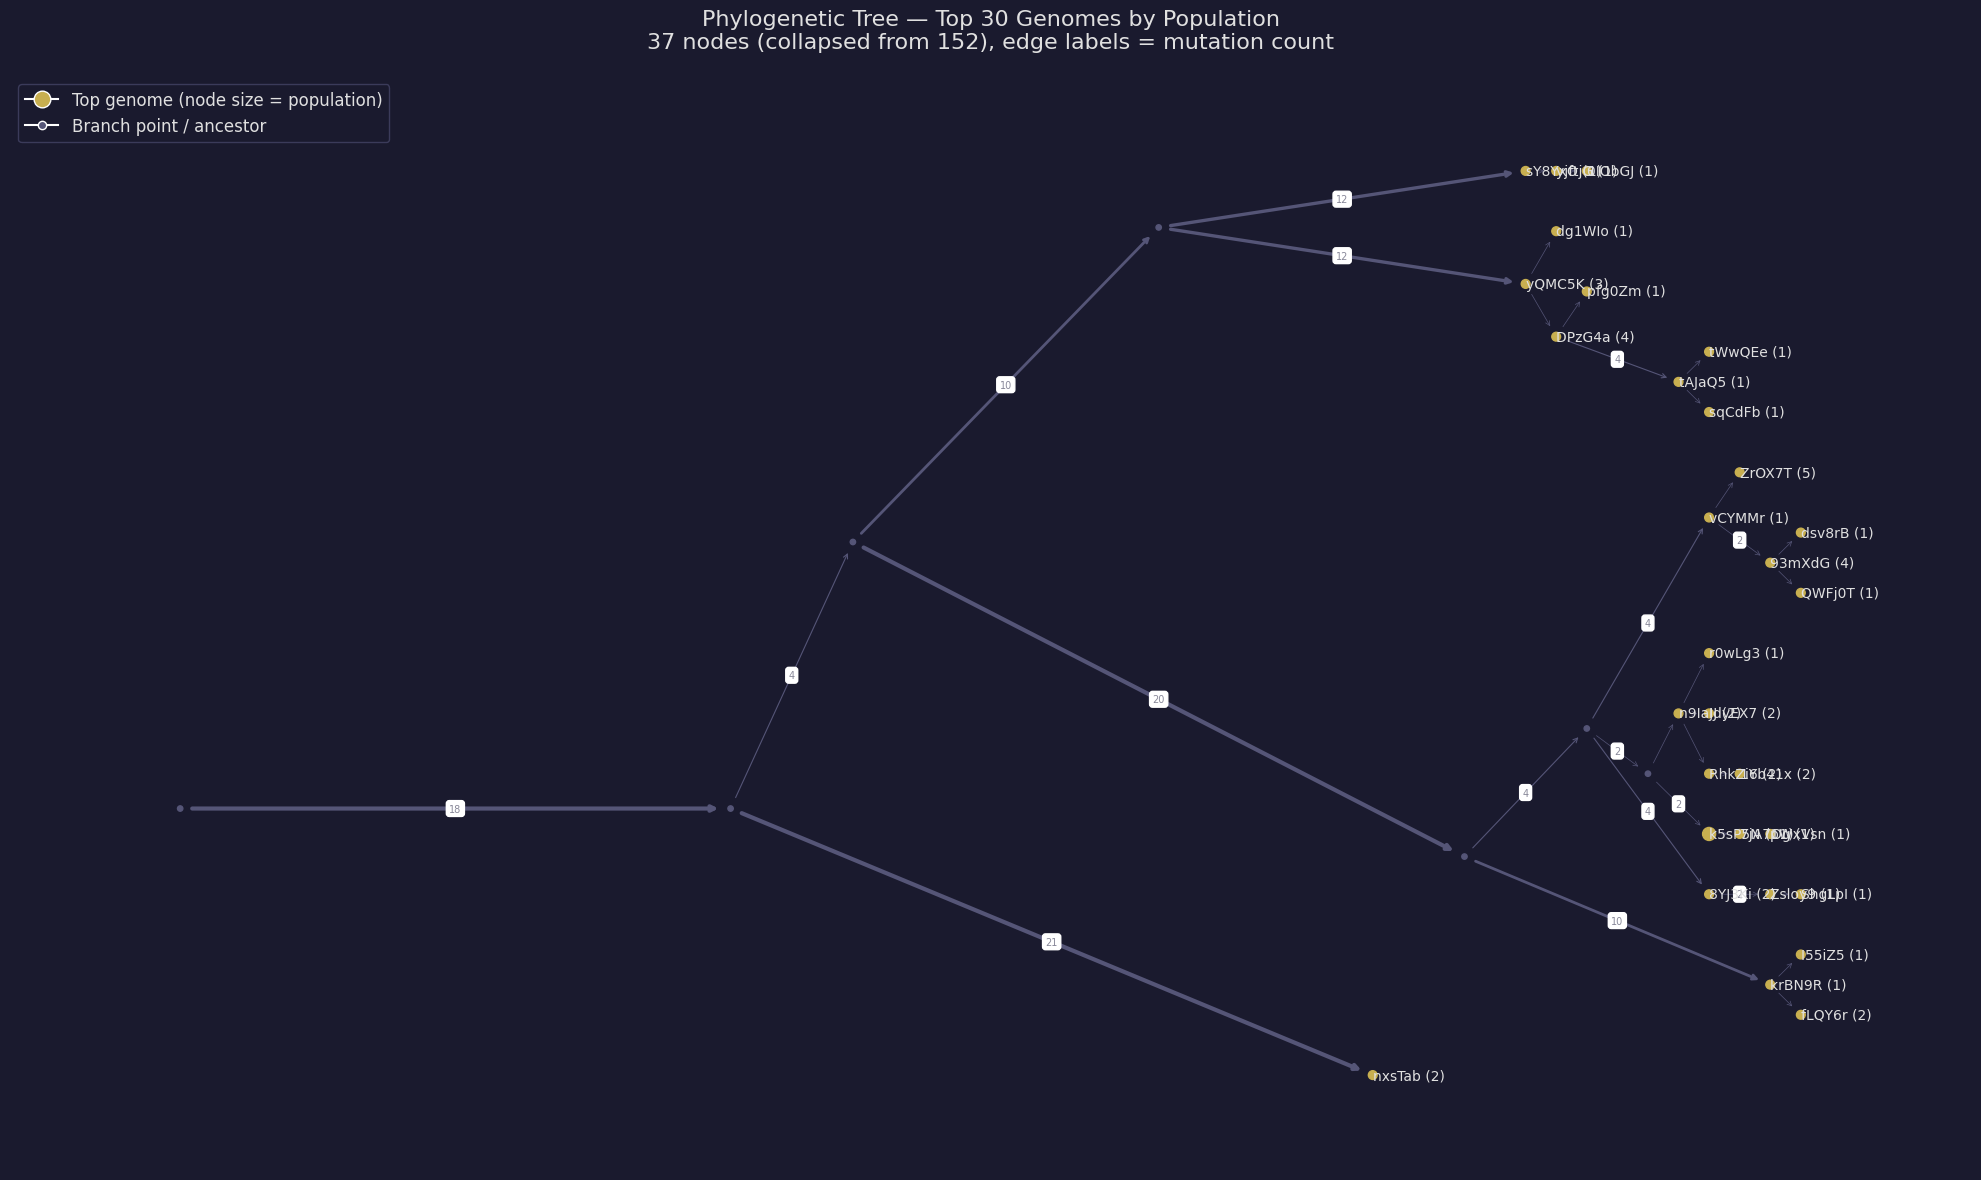

Showing top 30 genomes: 37 nodes, 36 edges


In [10]:
G = lineage_G
roots = lineage_roots
genome_depths = lineage_depths
genome_pop = lineage_genome_pop
active_genomes = lineage_active_genomes

# Prune to active lineages — only keep paths to top N genomes for readability
TOP_N_TREE = 30
top_genomes_tree = sorted(genome_pop.items(), key=lambda x: -x[1])[:TOP_N_TREE]
top_genome_set = {gh for gh, _ in top_genomes_tree}

keep = set()
for genome in top_genome_set:
    node = genome
    while node is not None:
        if node in keep:
            break
        keep.add(node)
        parents = list(G.predecessors(node))
        node = parents[0] if parents else None

G_pruned = G.subgraph(keep).copy()

# --- Collapse single-child chains ---
G_collapsed = nx.DiGraph()

def is_chain_node(n):
    """A node that has exactly 1 parent and 1 child and is not a top genome."""
    return (G_pruned.in_degree(n) == 1 and
            G_pruned.out_degree(n) == 1 and
            n not in top_genome_set)

key_nodes = set()
for n in G_pruned.nodes():
    if not is_chain_node(n):
        key_nodes.add(n)

for n in key_nodes:
    for child in G_pruned.successors(n):
        path_len = 1
        current = child
        while current not in key_nodes:
            successors = list(G_pruned.successors(current))
            if len(successors) != 1:
                break
            current = successors[0]
            path_len += 1
        if current in key_nodes:
            G_collapsed.add_edge(n, current, weight=path_len)

for n in key_nodes:
    if n not in G_collapsed:
        G_collapsed.add_node(n)

collapsed_roots = [n for n in G_collapsed.nodes() if G_collapsed.in_degree(n) == 0]

def tree_layout(G, roots):
    pos = {}
    leaf_cache = {}
    def count_leaves(node):
        if node in leaf_cache: return leaf_cache[node]
        children = list(G.successors(node))
        result = 1 if not children else sum(count_leaves(c) for c in children)
        leaf_cache[node] = result
        return result
    def place(node, top, bottom, x_offset):
        children = list(G.successors(node))
        if not children:
            pos[node] = (x_offset, (top + bottom) / 2)
            return
        sizes = [count_leaves(c) for c in children]
        total = sum(sizes)
        y = top
        for child, size in zip(children, sizes):
            h = (bottom - top) * size / total
            edge_data = G[node][child]
            edge_len = edge_data.get('weight', 1)
            place(child, y, y + h, x_offset + edge_len)
            y += h
        child_ys = [pos[c][1] for c in children]
        pos[node] = (x_offset, np.mean(child_ys))
    total_leaves = sum(count_leaves(r) for r in roots)
    y = 0
    for root in roots:
        sz = count_leaves(root)
        h = sz / total_leaves if total_leaves > 0 else 1
        place(root, y, y + h, 0)
        y += h
    return pos

sys.setrecursionlimit(50000)
pos = tree_layout(G_collapsed, collapsed_roots)

# Node appearance
node_sizes = []
node_colors = []
labels = {}
for n in G_collapsed.nodes():
    if n in top_genome_set:
        pop_count = genome_pop.get(n, 0)
        node_sizes.append(max(40, pop_count * 8))
        node_colors.append(GOLD)
        labels[n] = f'{format_genome_hash(n)} ({pop_count})'
    else:
        node_sizes.append(15)
        node_colors.append('#555577')

edge_widths = [max(0.5, min(3.0, G_collapsed[u][v].get('weight', 1) * 0.2))
               for u, v in G_collapsed.edges()]

# Add edge labels showing mutation count
edge_labels = {}
for u, v in G_collapsed.edges():
    w = G_collapsed[u][v].get('weight', 1)
    if w > 1:
        edge_labels[(u, v)] = str(w)

fig, ax = plt.subplots(figsize=(20, max(10, TOP_N_TREE * 0.4)))
nx.draw_networkx_edges(G_collapsed, pos, ax=ax, edge_color='#555577',
                       width=edge_widths, arrows=True, arrowsize=8,
                       arrowstyle='->')
nx.draw_networkx_nodes(G_collapsed, pos, ax=ax, node_size=node_sizes,
                       node_color=node_colors)
nx.draw_networkx_labels(G_collapsed, pos, labels, ax=ax, font_size=10,
                        font_color='#e0e0e0', horizontalalignment='left')
nx.draw_networkx_edge_labels(G_collapsed, pos, edge_labels, ax=ax,
                             font_size=7, font_color='#888899',
                             label_pos=0.5, rotate=False)

ax.set_title(
    f'Phylogenetic Tree — Top {TOP_N_TREE} Genomes by Population\n'
    f'{G_collapsed.number_of_nodes()} nodes (collapsed from {G_pruned.number_of_nodes()}), '
    f'edge labels = mutation count',
    fontsize=16, pad=20)

legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=GOLD,
           markersize=12, label=f'Top genome (node size = population)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#555577',
           markersize=6, label=f'Branch point / ancestor'),
]
ax.legend(handles=legend, loc='upper left', fontsize=12)
ax.axis('off')
plt.tight_layout()
plt.show()

print(f"Showing top {TOP_N_TREE} genomes: {G_collapsed.number_of_nodes()} nodes, {G_collapsed.number_of_edges()} edges")

The radial tree below shows the same active lineage data in a circular layout, including
all active genomes (not just the top 30).

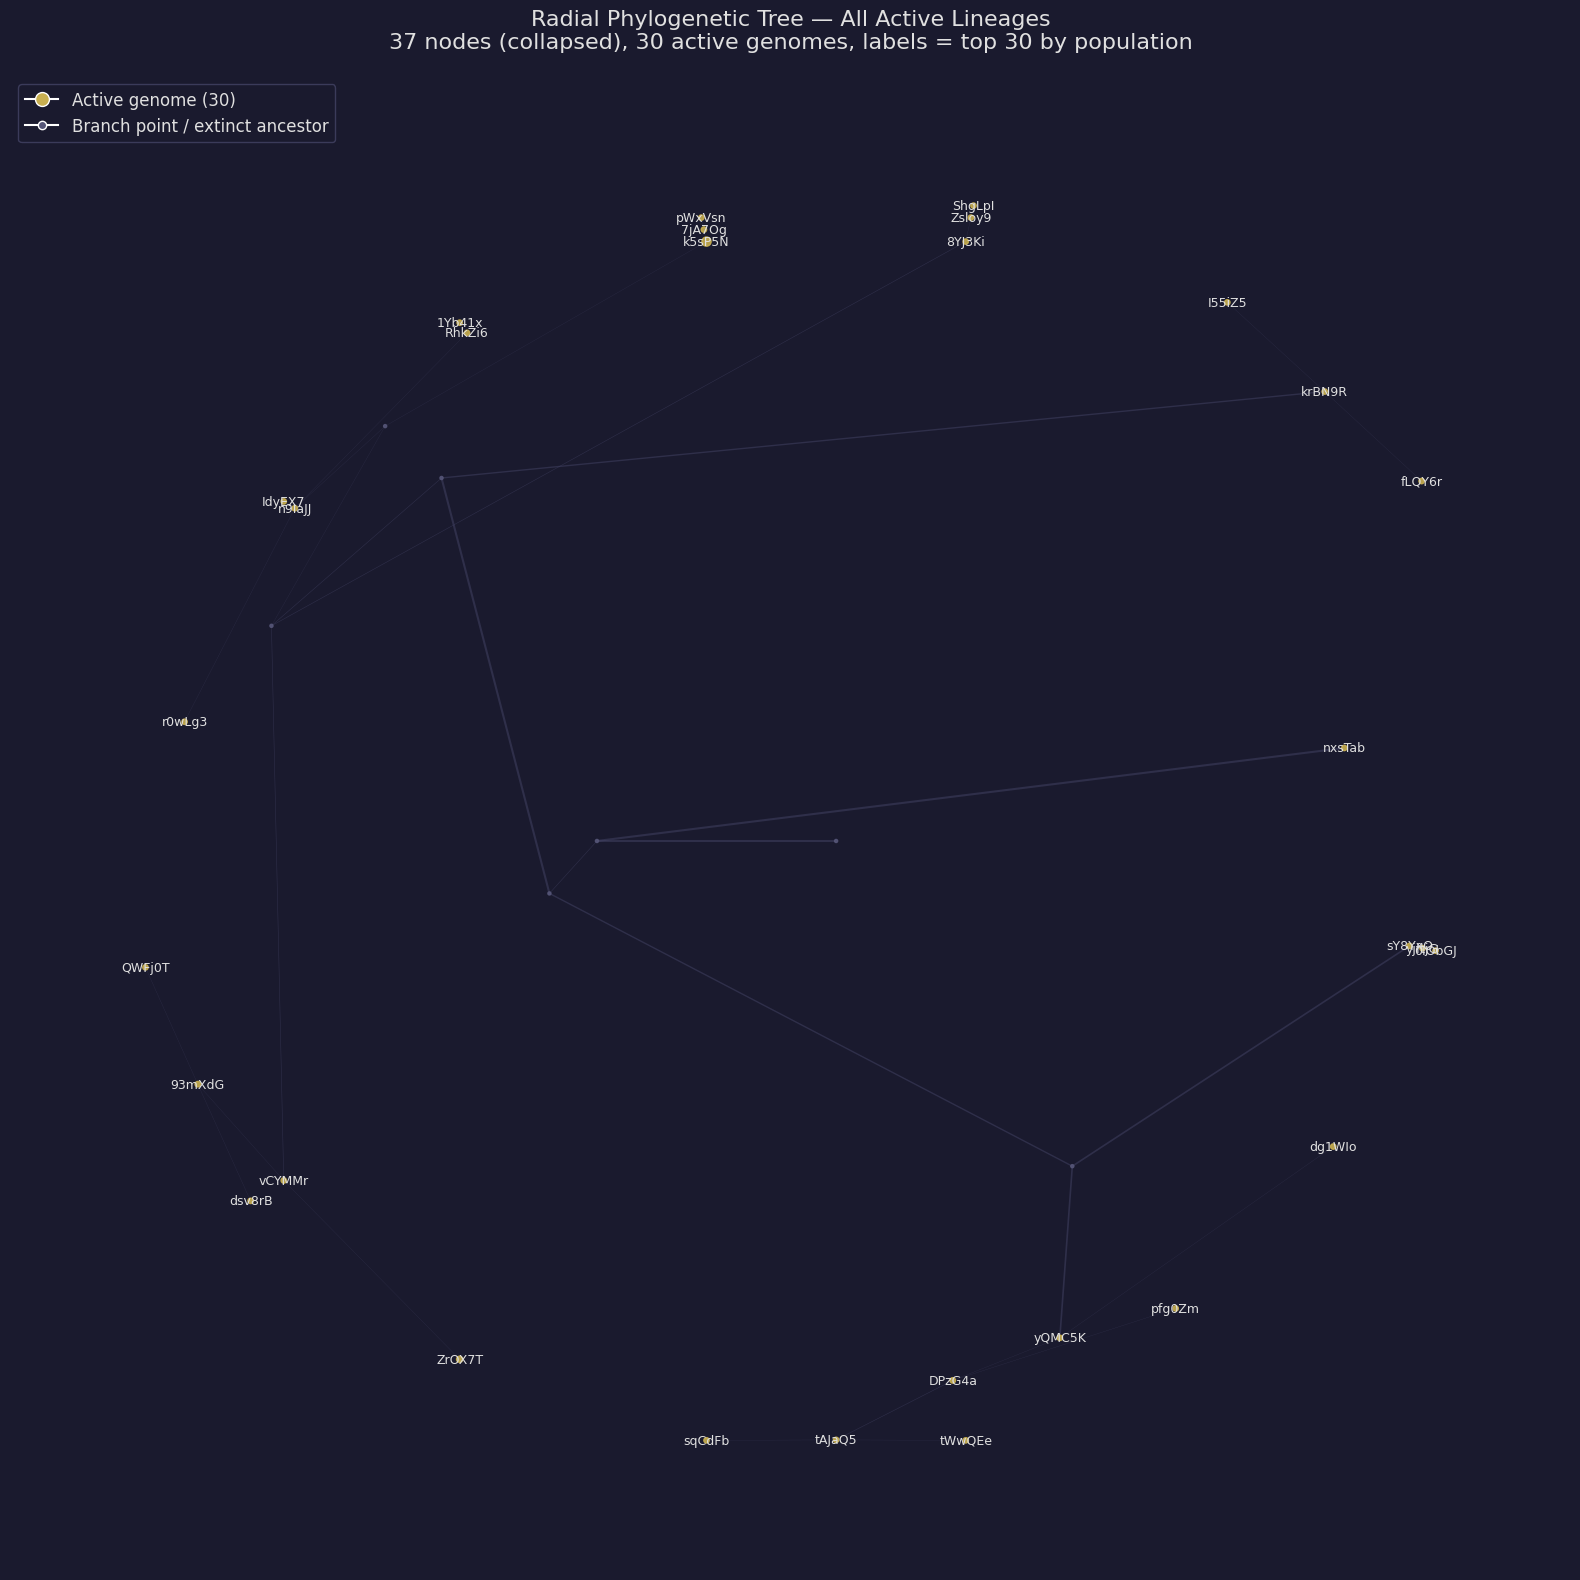

In [11]:
G = lineage_G
genome_pop = lineage_genome_pop
active_genomes = lineage_active_genomes

# --- Radial layout of the FULL active tree ---
# Prune all active genomes (not just top N) for the radial view
keep_all = set()
for genome in active_genomes:
    node = genome
    while node is not None:
        if node in keep_all:
            break
        keep_all.add(node)
        parents = list(G.predecessors(node))
        node = parents[0] if parents else None

G_full_pruned = G.subgraph(keep_all).copy()

# Collapse chains for the full tree too
G_full_collapsed = nx.DiGraph()
def is_chain_full(n):
    return (G_full_pruned.in_degree(n) == 1 and
            G_full_pruned.out_degree(n) == 1 and
            n not in active_genomes)

key_full = {n for n in G_full_pruned.nodes() if not is_chain_full(n)}
for n in key_full:
    for child in G_full_pruned.successors(n):
        path_len = 1
        current = child
        while current not in key_full:
            successors = list(G_full_pruned.successors(current))
            if len(successors) != 1: break
            current = successors[0]
            path_len += 1
        if current in key_full:
            G_full_collapsed.add_edge(n, current, weight=path_len)
for n in key_full:
    if n not in G_full_collapsed:
        G_full_collapsed.add_node(n)

radial_roots = [n for n in G_full_collapsed.nodes() if G_full_collapsed.in_degree(n) == 0]

def radial_layout(G, roots):
    pos = {}
    leaf_cache = {}
    def count_leaves(node):
        if node in leaf_cache: return leaf_cache[node]
        children = list(G.successors(node))
        result = 1 if not children else sum(count_leaves(c) for c in children)
        leaf_cache[node] = result
        return result
    def place(node, angle_start, angle_end, radius):
        children = list(G.successors(node))
        pos[node] = (radius * np.cos((angle_start + angle_end) / 2),
                     radius * np.sin((angle_start + angle_end) / 2))
        if not children: return
        sizes = [count_leaves(c) for c in children]
        total = sum(sizes)
        angle = angle_start
        for child, size in zip(children, sizes):
            a_span = (angle_end - angle_start) * size / total
            edge_data = G[node][child]
            edge_len = edge_data.get('weight', 1)
            place(child, angle, angle + a_span, radius + edge_len * 0.3)
            angle += a_span
    if len(roots) == 1:
        place(roots[0], 0, 2 * np.pi, 0)
    else:
        total_leaves = sum(count_leaves(r) for r in roots)
        angle = 0
        for root in roots:
            sz = count_leaves(root)
            span = 2 * np.pi * sz / total_leaves
            place(root, angle, angle + span, 0)
            angle += span
    return pos

pos_radial = radial_layout(G_full_collapsed, radial_roots)

# Node appearance for full tree
radial_sizes = []
radial_colors = []
for n in G_full_collapsed.nodes():
    if n in active_genomes:
        radial_sizes.append(max(15, genome_pop.get(n, 0) * 4))
        radial_colors.append(GOLD)
    else:
        radial_sizes.append(5)
        radial_colors.append('#555577')

radial_widths = [max(0.2, min(1.5, G_full_collapsed[u][v].get('weight', 1) * 0.1))
                 for u, v in G_full_collapsed.edges()]

fig, ax = plt.subplots(figsize=(16, 16))
nx.draw_networkx_edges(G_full_collapsed, pos_radial, ax=ax, edge_color='#444466',
                       width=radial_widths, arrows=False, alpha=0.5)
nx.draw_networkx_nodes(G_full_collapsed, pos_radial, ax=ax, node_size=radial_sizes,
                       node_color=radial_colors, alpha=0.9)

# Label top genomes from the collapsed tree
radial_labels = {n: format_genome_hash(n)
                 for n in top_genome_set if n in pos_radial}
nx.draw_networkx_labels(G_full_collapsed, pos_radial, radial_labels, ax=ax,
                        font_size=9, font_color='#e0e0e0')

ax.set_title(
    f'Radial Phylogenetic Tree — All Active Lineages\n'
    f'{G_full_collapsed.number_of_nodes()} nodes (collapsed), '
    f'{len(active_genomes)} active genomes, '
    f'labels = top {len(radial_labels)} by population',
    fontsize=16, pad=20)

legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=GOLD,
           markersize=10, label=f'Active genome ({len(active_genomes)})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#555577',
           markersize=6, label=f'Branch point / extinct ancestor'),
]
ax.legend(handles=legend, loc='upper left', fontsize=12)
ax.axis('off')
plt.tight_layout()
plt.show()

**How to read these trees:**

- **Gold nodes** = genomes with currently living organisms. Node size reflects population count.
- **Gray nodes** = branch points where lineages diverged. These are typically extinct ancestors.
- **Collapsed tree (top):** Chains of single-mutation steps are compressed into single edges.
  Edge labels show the number of intermediate mutations. Node labels show a 6-character genome
  hash and the organism count for top genomes. This makes the branching structure readable
  even when the tree is deep.
- **Radial tree (bottom):** The same active lineage tree in a circular layout, including all
  active genomes (not just the top 30). The primordial ancestor sits at the center; the most
  derived genomes are at the periphery. Only the most abundant genomes are labeled.
- **Reading branching patterns:** A node with many children indicates a successful genome that
  spawned multiple variant lineages.

---
## 8. Muller Plot — Lineage Dynamics Over Time

A [Muller plot](https://en.wikipedia.org/wiki/Muller_plot) shows how lineage clades
rise and fall as nested stacked areas. Child lineages are visually nested within their
parents.

Genomes are grouped into **clades** by walking up the phylogenetic tree to a common
ancestor at a configurable depth. Higher depth values produce more granular clades
that reveal finer-grained dynamics.

Auto-selected clade depth: 21 (max tree depth: 64)
Tracking 194 clades (90% of organism-ticks)


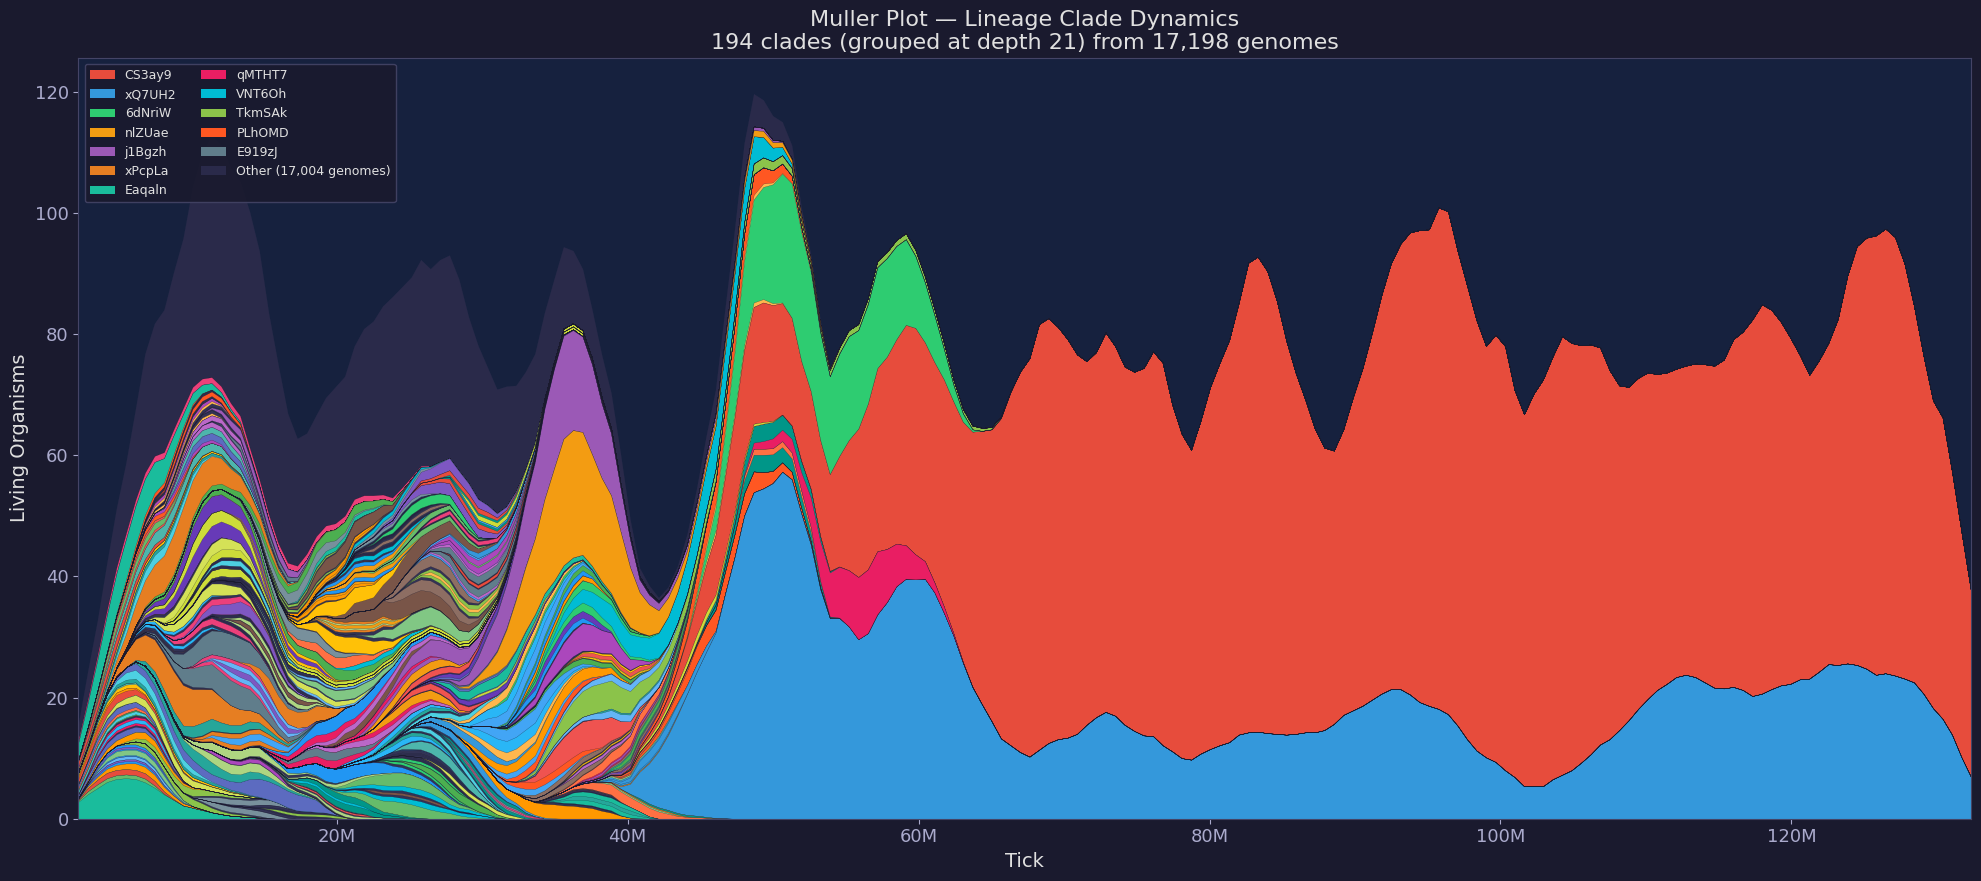

In [12]:
G = lineage_G
roots = lineage_roots
genome_depths = lineage_depths
tree_raw = lineage_tree_raw
sample_ticks = sorted(snapshots.keys())
max_depth = max(genome_depths.values()) if genome_depths else 0

# --- Configuration ---
CLADE_DEPTH = None    # None = auto-select, or set manually (e.g. 8, 15, 25)
CLADE_THRESHOLD = 0.03

def get_ancestor(genome, target_depth):
    d = genome_depths.get(genome, 0)
    node = genome
    while d > target_depth and node in G:
        parents = list(G.predecessors(node))
        if not parents: break
        node = parents[0]
        d = genome_depths.get(node, 0)
    return node

# Build per-tick genome frequency from snapshots
freq_raw = {}
for t in sample_ticks:
    snap = snapshots[t]
    counts = {}
    for o in snap['organisms']:
        if not o.get('isDead', False):
            gh = str(o['genomeHash'])
            counts[gh] = counts.get(gh, 0) + 1
    freq_raw[t] = counts

# Auto-select or use manual clade depth
if CLADE_DEPTH is not None:
    best_depth = CLADE_DEPTH
    print(f"Manual clade depth: {best_depth} (max tree depth: {max_depth})")
else:
    # Find the depth that produces a readable number of significant clades
    # (target 40-150). Start from 1/3 of max depth to ensure late-stage
    # splitting events are visible.
    MIN_DEPTH = max(1, max_depth // 3)
    best_depth = MIN_DEPTH

    for try_depth in range(MIN_DEPTH, max_depth):
        clade_peak_share = {}
        for t, counts in freq_raw.items():
            total = sum(counts.values())
            if total == 0: continue
            clade_counts = {}
            for gh, c in counts.items():
                anc = get_ancestor(gh, try_depth)
                clade_counts[anc] = clade_counts.get(anc, 0) + c
            for anc, c in clade_counts.items():
                share = c / total
                clade_peak_share[anc] = max(clade_peak_share.get(anc, 0), share)
        sig = sum(1 for v in clade_peak_share.values() if v >= CLADE_THRESHOLD)
        if 40 <= sig <= 150:
            best_depth = try_depth
            break
        elif sig > 150:
            best_depth = max(MIN_DEPTH, try_depth - 1)
            break

    print(f"Auto-selected clade depth: {best_depth} (max tree depth: {max_depth})")

# Group genomes into clades
freq = {}
for t, counts in freq_raw.items():
    clade_counts = {}
    for gh, c in counts.items():
        anc = get_ancestor(gh, best_depth)
        clade_counts[anc] = clade_counts.get(anc, 0) + c
    freq[t] = clade_counts

clade_set = set()
for t, counts in freq.items():
    total = sum(counts.values())
    if total > 0:
        for clade, c in counts.items():
            if c / total >= CLADE_THRESHOLD:
                clade_set.add(clade)

clade_totals = {}
for counts in freq.values():
    for clade, c in counts.items():
        clade_totals[clade] = clade_totals.get(clade, 0) + c

total_ot = sum(sum(c.values()) for c in freq_raw.values())
tracked_ot = sum(clade_totals.get(c, 0) for c in clade_set)
print(f"Tracking {len(clade_set)} clades ({100*tracked_ot/total_ot:.0f}% of organism-ticks)")

# Build clade subtree + Euler tour
relevant = set()
for c in clade_set:
    node = c
    while node is not None:
        if node in relevant: break
        relevant.add(node)
        if node not in G: break
        parents = list(G.predecessors(node))
        node = parents[0] if parents else None

G_clade = G.subgraph(relevant).copy()
clade_roots = sorted(n for n in G_clade.nodes() if G_clade.in_degree(n) == 0)

tour = []
def euler_visit(node):
    children = sorted(G_clade.successors(node))
    if not children:
        tour.append(node)
    else:
        tour.append(node)
        for child in children:
            euler_visit(child)
        tour.append(node)

for root in clade_roots:
    euler_visit(root)
appearances = Counter(tour)

tick_arr = np.array(sample_ticks, dtype=float)
n_samples = len(sample_ticks)
SMOOTH_WINDOW = 8

stacked = np.zeros((len(tour), n_samples))
for tick_idx, t in enumerate(sample_ticks):
    counts = freq[t]
    for tour_idx, clade in enumerate(tour):
        stacked[tour_idx, tick_idx] = counts.get(clade, 0) / appearances[clade]

for row in range(stacked.shape[0]):
    stacked[row] = smooth(stacked[row], SMOOTH_WINDOW)

cumulative = np.cumsum(stacked, axis=0)
cum_with_zero = np.vstack([np.zeros((1, n_samples)), cumulative])

other_raw = np.zeros(n_samples)
for tick_idx, t in enumerate(sample_ticks):
    total = sum(freq_raw[t].values())
    tracked = sum(freq[t].get(c, 0) for c in relevant)
    other_raw[tick_idx] = total - tracked
other = smooth(other_raw, SMOOTH_WINDOW)

clade_depths_map = {}
for root in clade_roots:
    clade_depths_map[root] = 0
    for u, v in nx.bfs_edges(G_clade, root):
        clade_depths_map[v] = clade_depths_map[u] + 1

PALETTE = [
    '#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6',
    '#e67e22', '#1abc9c', '#e91e63', '#00bcd4', '#8bc34a',
    '#ff5722', '#607d8b', '#795548', '#cddc39', '#4caf50',
    '#ff9800', '#2196f3', '#673ab7', '#009688', '#ffc107',
    '#5c6bc0', '#26a69a', '#ef5350', '#66bb6a', '#42a5f5',
    '#ab47bc', '#ec407a', '#7e57c2', '#29b6f6', '#d4e157',
    '#ff7043', '#78909c', '#8d6e63', '#aed581', '#4db6ac',
    '#ffb74d', '#64b5f6', '#ba68c8', '#4dd0e1', '#81c784',
]

clade_colors = {}
sorted_clades = sorted(clade_set, key=lambda x: -clade_totals.get(x, 0))
for i, c in enumerate(sorted_clades):
    clade_colors[c] = PALETTE[i % len(PALETTE)]
for c in relevant - clade_set:
    clade_colors[c] = '#333355'

fig, ax = plt.subplots(figsize=(20, 9))

total_tracked = cumulative[-1]
ax.fill_between(tick_arr, total_tracked, total_tracked + other,
                facecolor='#2a2a4a', edgecolor='#333355', linewidth=0.1)

for clade in sorted(set(tour), key=lambda g: clade_depths_map.get(g, 0)):
    indices = [i for i, g in enumerate(tour) if g == clade]
    bottom = cum_with_zero[indices[0]]
    top = cumulative[indices[-1]]
    ax.fill_between(tick_arr, bottom, top,
                    facecolor=clade_colors.get(clade, '#555577'),
                    edgecolor='#1a1a2e', linewidth=0.15)

ax.set_xlabel('Tick', fontsize=14)
ax.set_ylabel('Living Organisms', fontsize=14)
ax.set_xlim(tick_arr[0], tick_arr[-1])
ax.set_ylim(0, None)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(tick_fmt))

legend_clades = sorted_clades[:min(12, len(sorted_clades))]
handles = [Patch(facecolor=clade_colors[c], label=f'{format_genome_hash(c)}')
           for c in legend_clades]
handles.append(Patch(facecolor='#2a2a4a',
                     label=f'Other ({len(tree_raw) - len(clade_set):,} genomes)'))
ax.legend(handles=handles, loc='upper left', fontsize=9, framealpha=0.9, ncol=2)

ax.set_title(
    f'Muller Plot — Lineage Clade Dynamics\n'
    f'{len(clade_set)} clades (grouped at depth {best_depth}) '
    f'from {len(tree_raw):,} genomes',
    fontsize=16)

plt.tight_layout()
plt.show()

**How to read this chart:**

- Each **colored band** represents a clade — a group of related genomes sharing a common ancestor
  at the auto-selected depth level. The band's height shows the clade's absolute population size
  at each point in time.
- Bands are **nested**: child clades appear visually within their parent clade's area. A band
  that splits into multiple colors represents a lineage diversification event.
- The **dark "Other" band** at the top represents the long tail of minor genomes that individually
  never exceed the tracking threshold.
- The **legend** shows the most abundant clades by their genome hash identifier.
- **What to look for:** A band growing at the expense of others = competitive displacement.
  Multiple bands growing together = coexistence. A band appearing suddenly = a successful
  new mutation. A band disappearing = lineage extinction.

---
## 9. Population Census

A snapshot of the population at the final tick: which genomes are most common, how
old are their organisms, what are their energy reserves, and how deep are they in the
evolutionary tree?

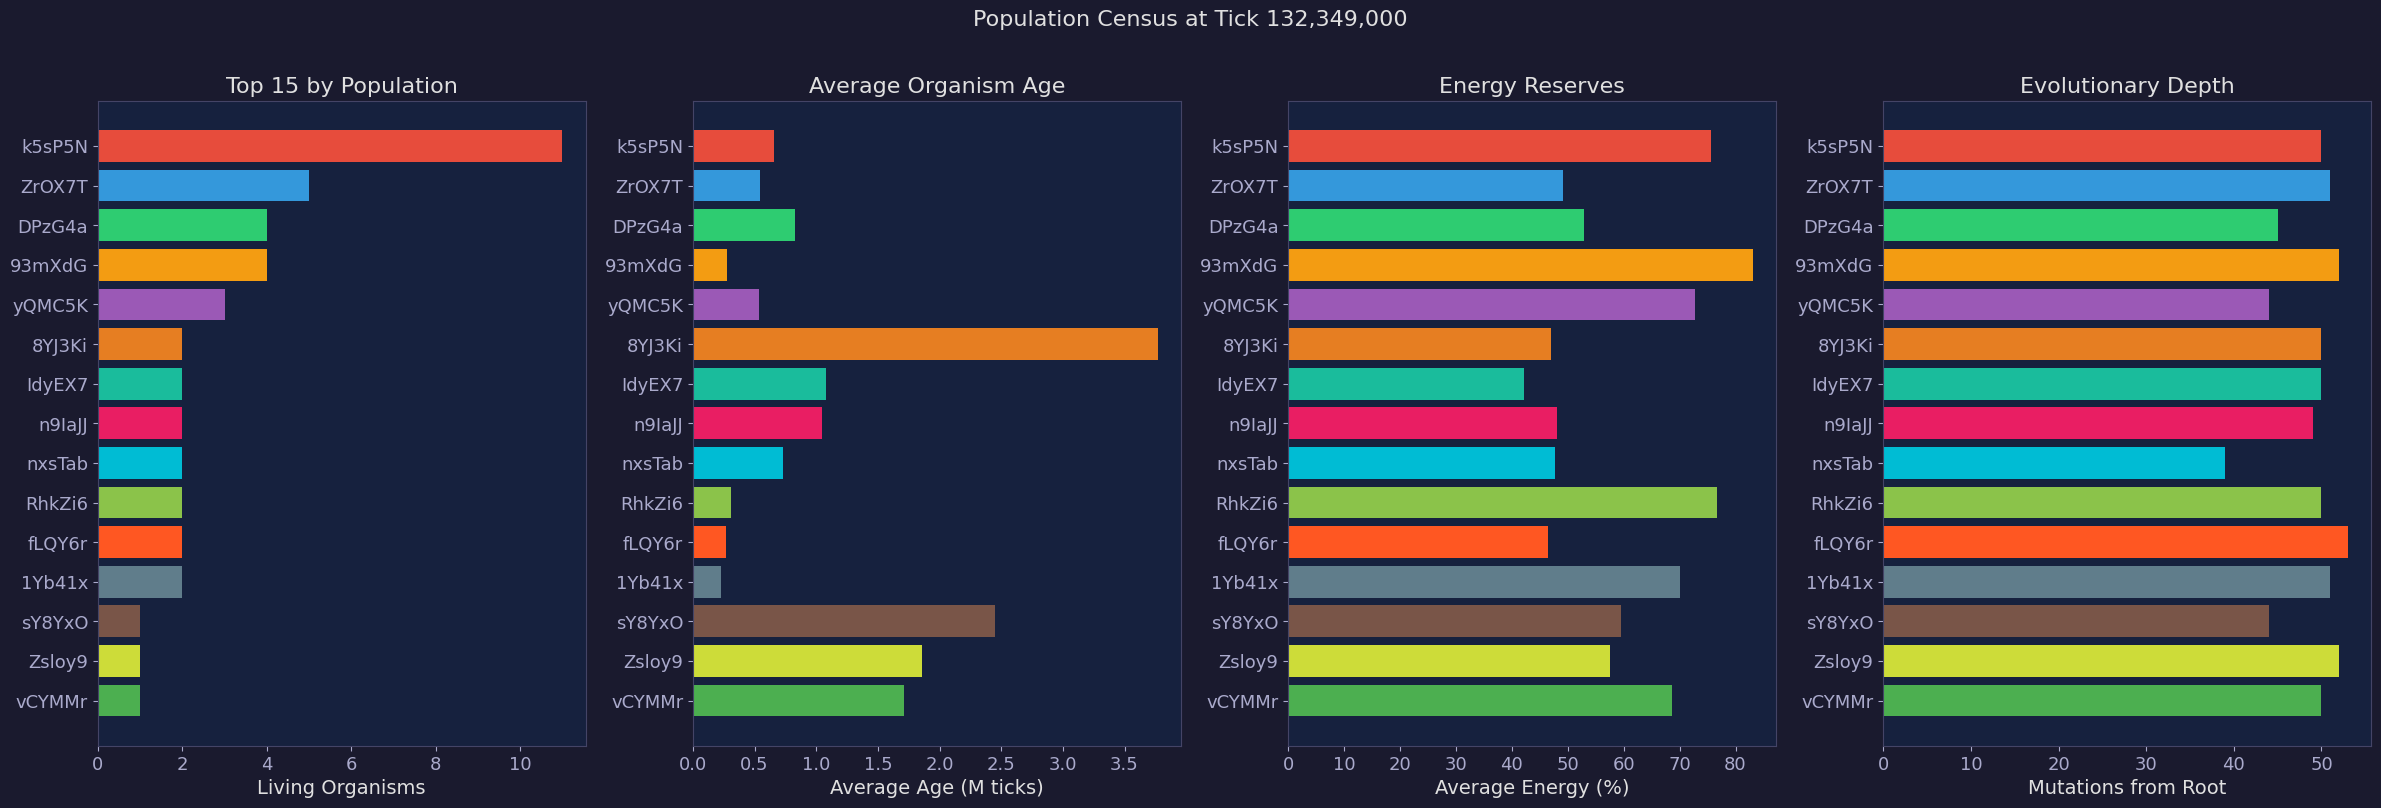

  Genome    Pop       Avg Age    Energy    Entropy   Depth
-----------------------------------------------------------------
  k5sP5N     11       660,925     75.6%       4.5%      50
  ZrOX7T      5       542,960     49.2%       2.8%      51
  DPzG4a      4       824,595     52.9%       7.5%      45
  93mXdG      4       273,949     83.1%      10.7%      52
  yQMC5K      3       535,282     72.8%      10.6%      44
  8YJ3Ki      2     3,767,762     47.1%      18.4%      50
  IdyEX7      2     1,078,428     42.3%       1.9%      50
  n9IaJJ      2     1,046,970     48.1%       2.6%      49
  nxsTab      2       731,080     47.7%       2.1%      39
  RhkZi6      2       305,246     76.6%       5.0%      50
  fLQY6r      2       266,098     46.4%       1.7%      53
  1Yb41x      2       224,512     70.1%       4.6%      51
  sY8YxO      1     2,447,906     59.6%      13.4%      44
  Zsloy9      1     1,857,865     57.5%       0.7%      52
  vCYMMr      1     1,713,102     68.6%      18.3

In [13]:
genome_depths = lineage_depths
genome_pop = lineage_genome_pop
alive = lineage_alive

genome_stats = {}
for o in alive:
    gh = str(o['genomeHash'])
    age = MAX_TICK - o['birthTick']
    genome_stats.setdefault(gh, []).append({
        'age': age,
        'energy_pct': o['energy'] / MAX_ENERGY * 100,
        'entropy_pct': o['entropyRegister'] / MAX_ENTROPY * 100
    })

top = sorted(genome_stats.items(), key=lambda x: -len(x[1]))[:15]
colors = [PALETTE[i % len(PALETTE)] for i in range(len(top))]

fig, axes = plt.subplots(1, 4, figsize=(24, 8))

labels = [format_genome_hash(gh) for gh, _ in top]
counts = [len(orgs) for _, orgs in top]

axes[0].barh(labels, counts, color=colors)
axes[0].set_xlabel('Living Organisms')
axes[0].set_title('Top 15 by Population')
axes[0].invert_yaxis()

avg_ages = [np.mean([o['age'] for o in orgs]) for _, orgs in top]
axes[1].barh(labels, [a / 1e6 for a in avg_ages], color=colors)
axes[1].set_xlabel('Average Age (M ticks)')
axes[1].set_title('Average Organism Age')
axes[1].invert_yaxis()

avg_energy = [np.mean([o['energy_pct'] for o in orgs]) for _, orgs in top]
axes[2].barh(labels, avg_energy, color=colors)
axes[2].set_xlabel('Average Energy (%)')
axes[2].set_title('Energy Reserves')
axes[2].invert_yaxis()

dep = [genome_depths.get(gh, 0) for gh, _ in top]
axes[3].barh(labels, dep, color=colors)
axes[3].set_xlabel('Mutations from Root')
axes[3].set_title('Evolutionary Depth')
axes[3].invert_yaxis()

plt.suptitle(f'Population Census at Tick {MAX_TICK:,}', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

# Summary table
print(f"{'Genome':>8s}  {'Pop':>5s}  {'Avg Age':>12s}  {'Energy':>8s}  {'Entropy':>9s}  {'Depth':>6s}")
print('-' * 65)
for gh, orgs in top:
    avg_a = np.mean([o['age'] for o in orgs])
    avg_e = np.mean([o['energy_pct'] for o in orgs])
    avg_s = np.mean([o['entropy_pct'] for o in orgs])
    d = genome_depths.get(gh, 0)
    print(f"{format_genome_hash(gh):>8s}  {len(orgs):5d}  {avg_a:12,.0f}  {avg_e:7.1f}%  {avg_s:8.1f}%  {d:6d}")

**How to read this chart:**

- **Population (1st panel):** How many living organisms carry this genome. The most common genome
  is at the top.
- **Average age (2nd panel):** How long organisms of this genome have been alive on average.
  High age = long-lived organisms; low age = organisms are young, either because the genome
  appeared recently or because its organisms reproduce frequently and die young.
- **Energy reserves (3rd panel):** Average energy as a percentage of maximum. High energy suggests
  the genome is efficient at gathering or conserving energy.
- **Evolutionary depth (4th panel):** Number of mutations separating this genome from the primordial
  ancestor. Higher depth = more evolutionary history.
- **Summary table:** Exact numbers are printed below the charts for all four dimensions plus entropy.

---
## How to Explore Further

This notebook demonstrates the main patterns for analyzing Evochora simulation data.
Here is how to build on them for your own analyses.

**Time-series metrics** are fetched as Parquet via the Analyzer API (see the setup cell).
The `metrics` dictionary contains standard pandas DataFrames — all share a `tick` column,
so joining them is straightforward (section 10 shows this with DuckDB SQL). Query the
`/analyzer/api/manifest` endpoint to discover all available metrics and their columns.

**Organism-level data** comes from the Visualizer API. Each snapshot (see the setup cell
for the lineage fetch and the Muller plot cell for time-series sampling) contains every
organism's state and the complete `genomeLineageTree` — a dict mapping each genome hash
to its parent. The phylogenetic tree sections show how to turn this into a NetworkX graph
and prune it to active lineages.

**Local Parquet files:** When running your own simulations, the Parquet files are stored
directly in the simulation's storage directory. You can skip the API and point DuckDB or
pandas at the files on disk for the fastest possible analysis.

**Custom analytics plugins:** All metrics in this notebook are produced by Java plugins
that receive every tick's state and output Parquet automatically. You can write your own —
see the [existing plugins](https://github.com/evochora/evochora/tree/main/src/main/java/org/evochora/datapipeline/services/analytics/plugins)
for examples.

### Adjusting This Notebook

- **Change the run:** Set `RUN_ID` in the configuration cell to analyze a different simulation run.
- **Adjust Muller plot granularity:** Set `CLADE_DEPTH` at the top of the Muller plot cell.

### References

- [API Documentation](https://evochora.org/api-docs/) — Interactive OpenAPI reference for all endpoints
- [Scientific Overview](https://github.com/evochora/evochora/blob/main/docs/SCIENTIFIC_OVERVIEW.md) — Design principles and thermodynamic model
- [Assembly Specification](https://github.com/evochora/evochora/blob/main/docs/ASSEMBLY_SPEC.md) — The EvoASM instruction set that organisms execute

---
## 10. Cross-Metric Analysis with DuckDB

The sections above each examine one metric in isolation. DuckDB lets us join multiple
metrics by tick and ask cross-cutting questions from an evolutionary biology perspective:
**density-dependent reproduction**, **mortality dynamics**, and **competitive advantage
during population bottlenecks**.

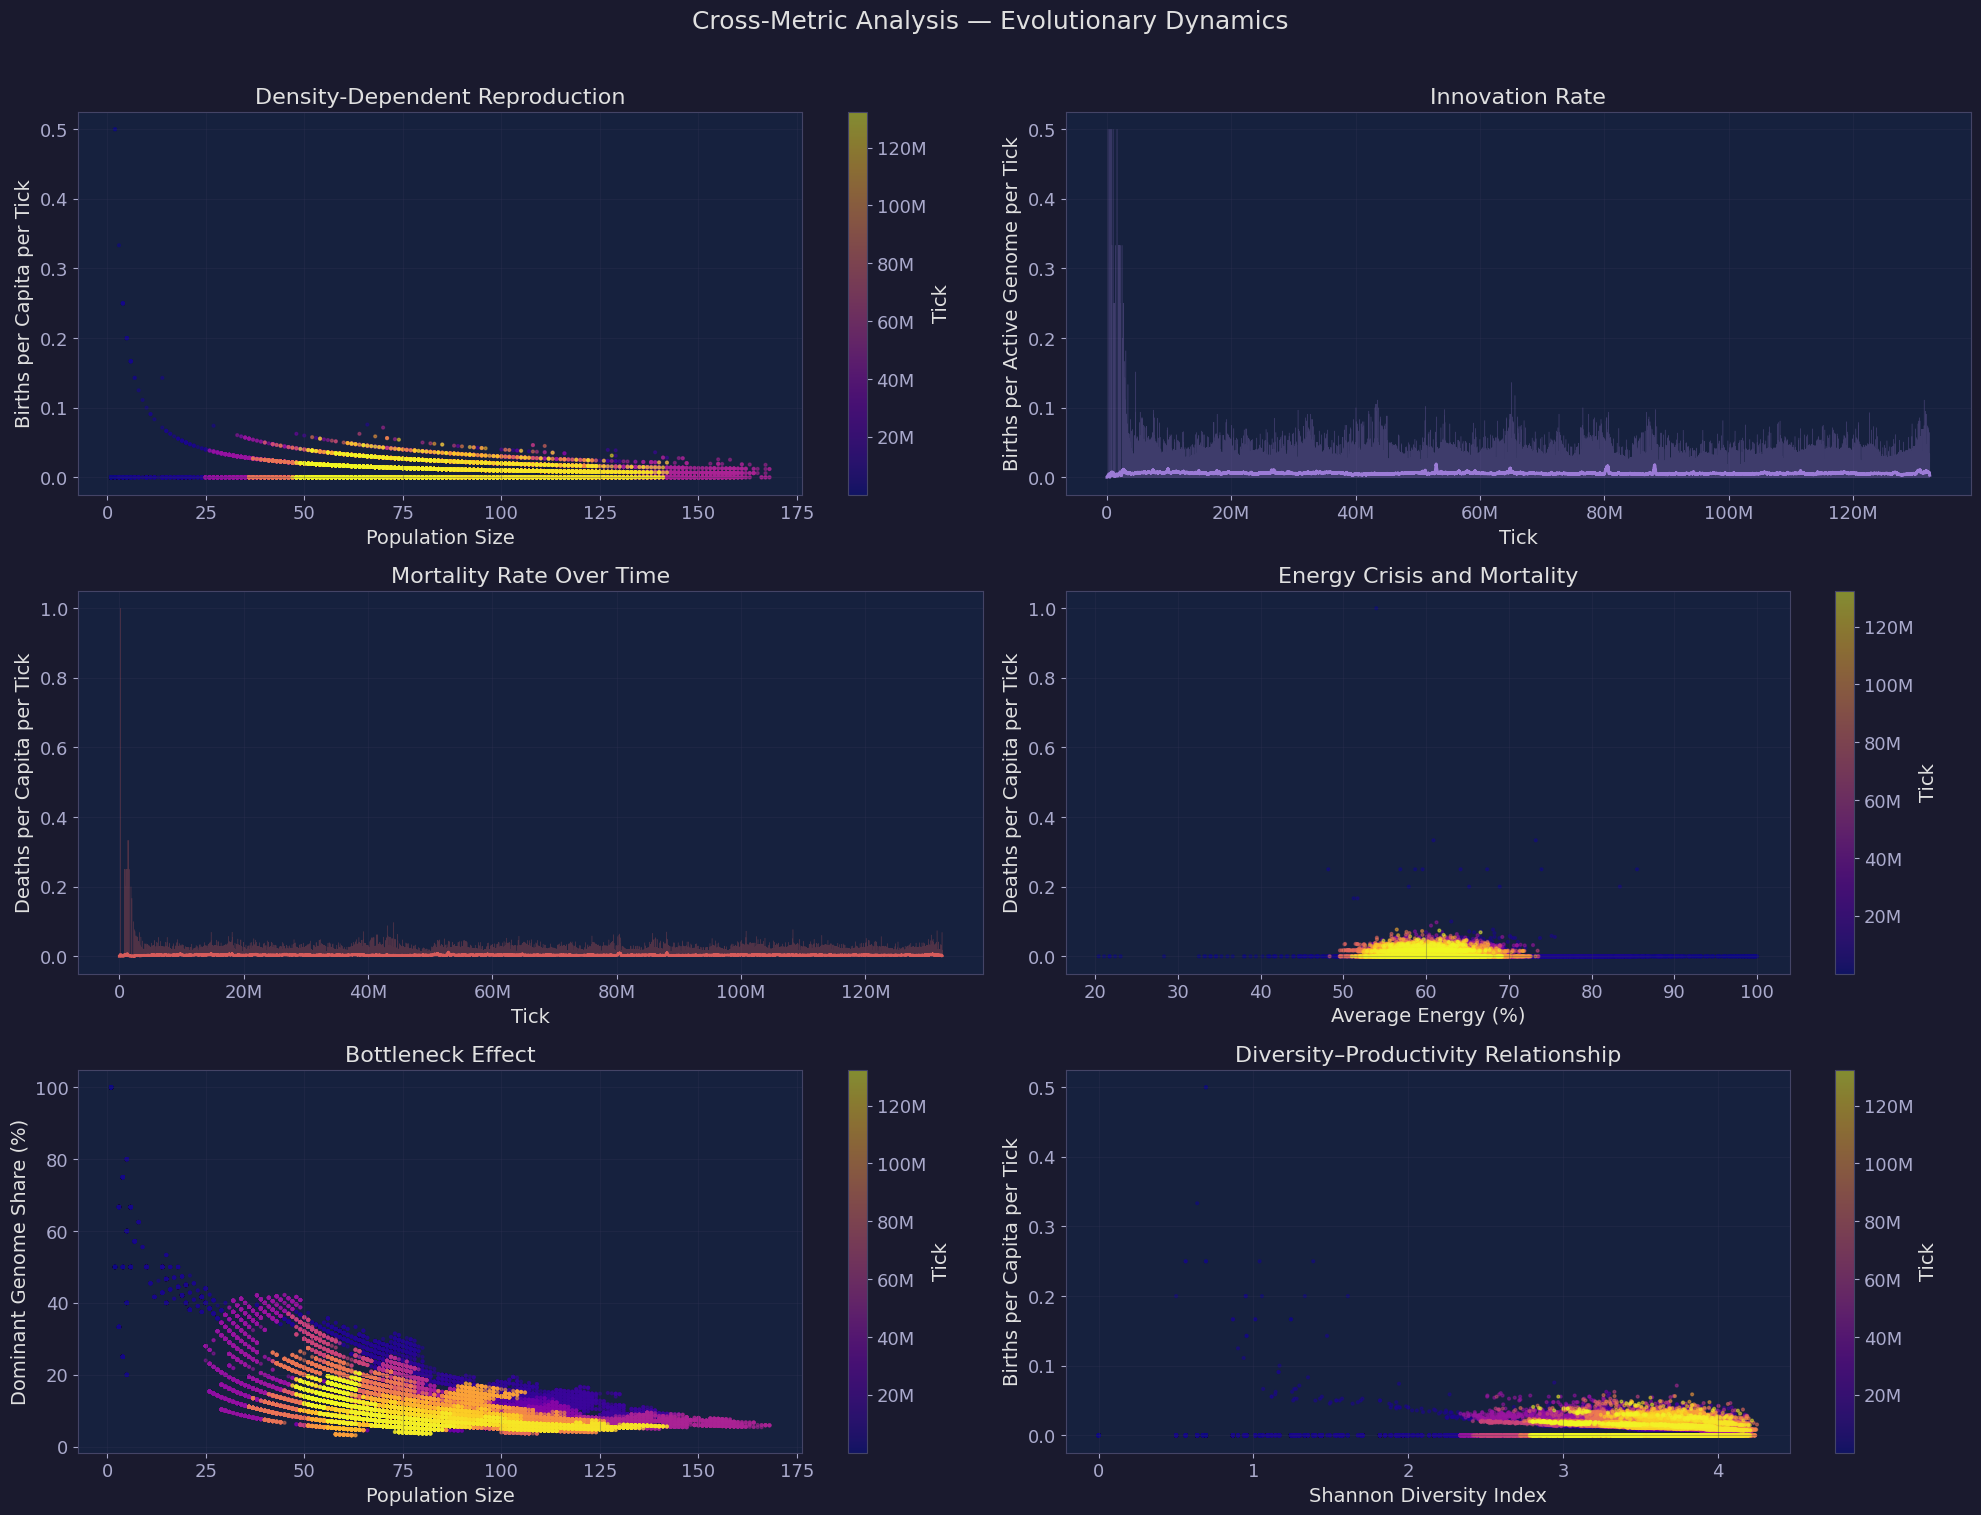

Density vs. reproduction:    r = 0.033
Energy vs. mortality:        r = -0.036
Population vs. dominance:    r = -0.581


In [14]:
try:
    import duckdb
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "duckdb"])
    import duckdb

pop = metrics["population"]
vs = metrics["vital_stats"]
div = metrics["genome_diversity"]

# Join all metrics and compute derived evolutionary indicators
cross = duckdb.sql("""
    SELECT
        p.tick,
        p.alive_count,
        p.avg_energy,
        d.shannon_index,
        d.active_genomes,
        d.dominant_share,
        v.total_born - LAG(v.total_born) OVER (ORDER BY p.tick) AS births,
        p.alive_count - LAG(p.alive_count) OVER (ORDER BY p.tick) AS pop_change
    FROM pop p
    JOIN vs v ON p.tick = v.tick
    JOIN div d ON p.tick = d.tick
    WHERE p.alive_count > 0
    ORDER BY p.tick
""").fetchdf().dropna()

cross['deaths'] = (cross['births'] - cross['pop_change']).clip(lower=0)
cross['births_per_capita'] = cross['births'] / cross['alive_count']
cross['death_rate'] = cross['deaths'] / cross['alive_count']
cross['births_per_genome'] = cross['births'] / cross['active_genomes'].replace(0, np.nan)

SM_CROSS = 200
for col in ['births_per_capita', 'death_rate', 'births_per_genome']:
    cross[f'{col}_smooth'] = pd.Series(
        smooth(cross[col].fillna(0).values, SM_CROSS), index=cross.index)

fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# --- a) Reproductive Output ---
ax = axes[0, 0]
sc = ax.scatter(cross['alive_count'], cross['births_per_capita'],
                c=cross['tick'], cmap='plasma', s=4, alpha=0.5)
plt.colorbar(sc, ax=ax, label='Tick', format=mticker.FuncFormatter(tick_fmt))
ax.set_xlabel('Population Size')
ax.set_ylabel('Births per Capita per Tick')
ax.set_title('Density-Dependent Reproduction')
ax.grid(True)

ax = axes[0, 1]
ax.plot(cross['tick'], cross['births_per_genome'], color=PURPLE, linewidth=0.3, alpha=0.3)
ax.plot(cross['tick'], cross['births_per_genome_smooth'], color=PURPLE, linewidth=2)
ax.set_xlabel('Tick')
ax.set_ylabel('Births per Active Genome per Tick')
ax.set_title('Innovation Rate')
ax.grid(True)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(tick_fmt))

# --- b) Survival Dynamics ---
ax = axes[1, 0]
ax.plot(cross['tick'], cross['death_rate'], color=RED, linewidth=0.3, alpha=0.3)
ax.plot(cross['tick'], cross['death_rate_smooth'], color=RED, linewidth=2)
ax.set_xlabel('Tick')
ax.set_ylabel('Deaths per Capita per Tick')
ax.set_title('Mortality Rate Over Time')
ax.grid(True)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(tick_fmt))

ax = axes[1, 1]
sc = ax.scatter(cross['avg_energy'], cross['death_rate'],
                c=cross['tick'], cmap='plasma', s=4, alpha=0.5)
plt.colorbar(sc, ax=ax, label='Tick', format=mticker.FuncFormatter(tick_fmt))
ax.set_xlabel('Average Energy (%)')
ax.set_ylabel('Deaths per Capita per Tick')
ax.set_title('Energy Crisis and Mortality')
ax.grid(True)

# --- c) Competitive Advantage ---
ax = axes[2, 0]
sc = ax.scatter(cross['alive_count'], cross['dominant_share'] * 100,
                c=cross['tick'], cmap='plasma', s=4, alpha=0.5)
plt.colorbar(sc, ax=ax, label='Tick', format=mticker.FuncFormatter(tick_fmt))
ax.set_xlabel('Population Size')
ax.set_ylabel('Dominant Genome Share (%)')
ax.set_title('Bottleneck Effect')
ax.grid(True)

ax = axes[2, 1]
sc = ax.scatter(cross['shannon_index'], cross['births_per_capita'],
                c=cross['tick'], cmap='plasma', s=4, alpha=0.5)
plt.colorbar(sc, ax=ax, label='Tick', format=mticker.FuncFormatter(tick_fmt))
ax.set_xlabel('Shannon Diversity Index')
ax.set_ylabel('Births per Capita per Tick')
ax.set_title('Diversity\u2013Productivity Relationship')
ax.grid(True)

plt.suptitle('Cross-Metric Analysis \u2014 Evolutionary Dynamics', fontsize=18, y=1.01)
plt.tight_layout()
plt.show()

# Correlation summary
corr_density = cross['alive_count'].corr(cross['births_per_capita'])
corr_energy = cross['avg_energy'].corr(cross['death_rate'])
corr_bottleneck = cross['alive_count'].corr(cross['dominant_share'])
print(f"Density vs. reproduction:    r = {corr_density:.3f}")
print(f"Energy vs. mortality:        r = {corr_energy:.3f}")
print(f"Population vs. dominance:    r = {corr_bottleneck:.3f}")

**How to read these charts:**

- **Density-dependent reproduction** (top-left): Does per-capita birth rate decrease at higher
  population density? A negative correlation indicates resource competition limiting reproduction —
  a hallmark of ecological carrying capacity.
- **Innovation rate** (top-right): Births per active genome over time. A declining rate means
  fewer births are needed per genome to sustain the population — the population is settling into
  fewer, more successful lineages.
- **Mortality rate** (middle-left): Deaths per capita over time. Declining mortality may indicate
  evolutionary adaptation to the environment.
- **Energy crisis and mortality** (middle-right): A negative correlation (higher energy = fewer
  deaths) confirms that energy is a key survival factor. The time coloring reveals whether this
  relationship changes as the population evolves.
- **Bottleneck effect** (bottom-left): When the population crashes, does a single genome take over?
  High dominant share at low population size indicates a genetic bottleneck — reduced diversity
  from a population crash.
- **Diversity–productivity relationship** (bottom-right): Is a diverse population more or less
  reproductively active? In ecology, the relationship between biodiversity and productivity is
  a central research question.